 ### BFH Car Competition

__Who are we?__
We are the Team "RandomForest". 
The team consits of __Simon Huber, Manuel Müller, Sevda Cürük and Solomun Araya__

---

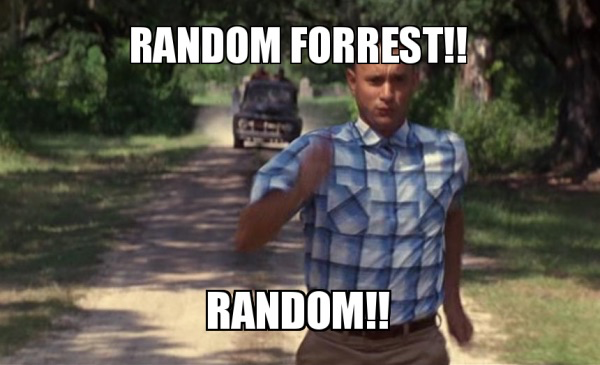


> It is said, that the Team "RandomForest" is one to be aware of! ;)

---
__What are we doing?__

The setup as described in the task is following:
We are _(pretending to be)_ recently hired __data scientists__ by a company to build a machine learning concept for predicting car prices. The company buys cars to resell them. Therefore, it is highly useful to have a system which predicts the car prices based on different features of the car. Nowdays, the company bases the prices on gut feelings, but with our system, the company is going to be able to predict car on old data.
Also, we can gain a lot of insights for our company on which are the main attributes to influence the price.
Without the possibilities of machine learning we would continue to trust our gut feeling and compare our cars with similar cars on the internet.
This could be a real world task as a data scientist.

For real we are students at the **Bern University of Applied Sciences** and this notebook is a task in our data science course.
We're competing against our classmates in a [Kaggle Competition](https://www.kaggle.com/c/bfh-ds-competition-2020).
The team which makes the best predictions on a test set wins.


So we are trying to solve the above described business case and at the same time we want for sure beat our classmates in the competition and build the best model.

---

__Data__

Our data on which our model is based on was crawled by an algorithm on "Ebay Kleinanzeigen" (a German reselling website). In this dataset (our `Train` data), every single car is described by following attributes:

- dateCrawled: When this ad was first crawled, all field-values are taken from this date
- name: Name of the car
- seller: Private or dealer
- offerType
- price: The price on the ad to sell the car
- abtest
- vehicleType
- yearOfRegistration: On which year the car was first registered
- gearbox
- powerPS: Power of the car in PS (pferdestärke)
- model: For example Kangoo of the brand Renault
- kilometer: How many kilometers the car has driven
- monthOfRegistration: On which month the car was first registered
- fuelType
- brand
- notRepairedDamage: If the car has a damage which is not repaired yet
- dateCreated: The date for which the ad at eBay was created
- nrOfPictures: Number of pictures in the ad
- postalCode
- lastSeenOnline: When the crawler saw this ad last online

A second Dataset called `Test` is created just to evaluate the model performance. It's actually a slice of the whole car dataset but `Since the target value to predict on is the feature price`, this feature was removed before we started to work with the dataset. Therefore, predictions can be compared to the actual sales price, and hence its performance. 


>Based on our data and our goal, we can assume that this will be a common supervised regression task.

---
__Performance__

The performance of the model is measured with the Root Mean Squared Error: 

$$ \mbox{RMSE} = \sqrt{\frac{1}{m}\sum_{i=1}^m \left(\hat{y}_i - y_i\right)^2}$$

---
__How we gonna reach our goal?__

Knowledge and a huge amount of try, try, try. The aim goal is to go step-by-step towards the target of an acceptable RMSE score. Therefore, we are going to use `supervised`machine learning algorythms. After preprocessing the datasets, with `feature importance` we are going to evaluate the most important parameters for tuning hyperparameters. Therefore, the score should icrease massively. 

---
__Why our model?__

So far, sales person of the company had to define all prices out of gut feeling. Although they built up a huge amount of knowledge over the last years in resaleing cars, prices were every thing else than optimized. An alternative would be to simply use excel, which is not that useful since we are talking here about a huge amount of data. Therefore, a machine learning model is highly recommended.

---
__Pre Assumptions__

We assume that the dataset contains several features with a very low correlation to our predictive feature `price`, such as:

- carId
- The name
- Date created
- nrOfPictures
- MonthOfRegistration
- lastSeenOnline

We asume (based on experience) that the **kilometers** and the **age** of the cars have a big influence on the reselling price.

Also we lost a thought about the distribution, the description and the shape of the two datasets `test`and `train`. It would be very useful, if they are similar distributed. 

We may be totally wrong with these assumptions. Hence, in the first chapter we will check the data to get an insight.

---
In the following paper, we are going to explain step by step how we did it.

## Import Libraries

In [1]:
# reload modules before executing user code
%load_ext autoreload
# reload all modules every time before executing Python code
%autoreload 2
# render plots in notebook
%matplotlib inline

In [2]:
%%capture
# uncomment to update the library if working locally
!pip install dslectures --upgrade

In [3]:
import jedi
from dslectures.core import display_large
from dslectures.structured import proc_df
from dslectures.core import (
    get_dataset,
    display_large,
    convert_strings_to_categories,
    rf_feature_importance,
    plot_feature_importance,
    plot_dendogram,
)
from pathlib import Path
from tqdm import tqdm
import time
from numpy.testing import assert_array_equal
from scipy import stats

#data wrangling
import pandas as pd
import numpy as np

#data visualisation
import seaborn as sns
import matplotlib.pyplot as plt

#machine learning
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor as MLP
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
#uncoment the following if you havent installed xgbost
#!pip install xgboost
import xgboost as xgb

np.warnings.filterwarnings('ignore')

In [4]:
datapath = Path('data/')

## Load the data

Because this is a Kaggle competition, the datasets are available on: https://www.kaggle.com/c/bfh-ds-competition-2020/data.

As said before, the data is crawled from the German website "Ebay Kleinanzeigen".

In [5]:
#load train and test data from .csv
train = pd.read_csv(datapath/'train.csv')
test = pd.read_csv(datapath/'test.csv')

---
**Create X and y**

To have a consistent score, which represents the score on the test set we have to cut off a validation set before the preprocessing. The main idea is that we should consider to preprocess the validation set the same way as the test set, that the RMSE score shown in our notebook below will not be massivly different from the RMSE score reached in the submission on kaggle.

In [6]:
#create the feature matrix X and the target vector y
X = train.drop('price', axis=1)
y = train['price']

In [7]:
#split the train set into a test and a train set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=42)

print(f"{len(X_train)} train rows + {len(X_valid)} valid rows")

211584 train rows + 37339 valid rows


In [8]:
#merge together the train set
train = X_train
train['price'] = y_train

#merge the validation set and save it for later
valid = X_valid
valid['price'] = y_valid
valid.to_csv(datapath/'valid1.csv', index = False)

train.shape, valid.shape

((211584, 21), (37339, 21))

## Data Exploration, Visualisation and Feature Engineering

### Inspect the data

As a first step, gaining a general overview, some insights of the Data. Therefore, it is helpful to use commands like `.shape, .info, .head(), .tail()`

In [9]:
train.shape, test.shape

((211584, 21), (122541, 20))

We can see, that the `trainset has 248923` rows and 21 columns. The `testset has 122541` rows and 20 columns. 
> Naturally, because the testset does not contain the to predicting feature 'price'. 

In [10]:
# ratio of trainset and testset
train_rat = str(round((100 / (train.shape[0]+valid.shape[0]+test.shape[0])) * train.shape[0],0))
valid_rat = str(round((100 / (train.shape[0]+valid.shape[0]+test.shape[0])) * valid.shape[0],0))
test_rat = str(round((100 / (train.shape[0]+valid.shape[0]+test.shape[0])) * test.shape[0],0))

print('Train Set: '+train_rat+'%')
print('Validation Set: '+valid_rat+'%')
print('Test Set: '+test_rat+'%')

Train Set: 57.0%
Validation Set: 10.0%
Test Set: 33.0%


Nice! The proportion of the two datasets are already optimally distributed. `The trainset + the validset is about 2/3 and the testset is about 1/3 of all datas availabl`.

---

In [11]:
#information on numerical data
train.describe()

,carId,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode,price
count,211584.000000,211584.000000,211584.000000,211584.000000,211584.000000,211584.0,211584.000000,2.115840e+05
mean,124419.009816,2004.523556,115.378658,125633.838097,5.729653,0.0,50845.825209,2.158354e+04
std,71878.343314,91.982199,177.083767,40103.053468,3.711832,0.0,25837.022731,4.720214e+06
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000,0.000000e+00
25%,62136.750000,1999.000000,70.000000,125000.000000,3.000000,0.0,30457.000000,1.150000e+03
50%,124428.500000,2003.000000,105.000000,150000.000000,6.000000,0.0,49610.000000,2.950000e+03
75%,186631.250000,2008.000000,150.000000,150000.000000,9.000000,0.0,71640.000000,7.200000e+03
max,248921.000000,9999.000000,19208.000000,150000.000000,12.000000,0.0,99998.000000,2.147484e+09


>__Important:__ our focusing variable is the numerical variable `price`. At the end we want to predict the price of the cars in the testset.

In [12]:
test.describe()

,carId,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
count,122541.000000,122541.000000,122541.000000,122541.000000,122541.000000,122541.0,122541.000000
mean,310193.000000,2004.630630,115.297264,125639.989881,5.743906,0.0,50759.542137
std,35374.684006,94.475329,189.115763,40100.543195,3.709798,0.0,25737.007288
min,248923.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,279558.000000,1999.000000,70.000000,125000.000000,3.000000,0.0,30519.000000
50%,310193.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49610.000000
75%,340828.000000,2008.000000,150.000000,150000.000000,9.000000,0.0,71336.000000
max,371463.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


> Note: Train and Test set have similar distributions. 

---
**Check Unique Values**

As we now know, the number of columns in the `trainset` is 211584. and in the`testset` is 122541. Therefore, since the 'carId' is the keyvalue to exactly identify any car in the dataset, the amount of unique carId's in the certain dataset should be equal to the number of rows within the dataset. Let us check that

In [13]:
train['carId'].nunique() == len(train), test['carId'].nunique() == len(test)

(True, True)

So basically, we just verified that __every car in our datasets does have a unique carId.__ So we do not have duplicated in our datasets, which is very good. Otherwise, we had to ged rid of duplicates.

---

### Types

The .dtypes allows us to get an overwiew of the features and their datatype, which will be important in later actions. To finally predict prices of the testset, it is necessaire to have only nummerical values. 

In [14]:
train.dtypes, test.dtypes

(carId                   int64
 dateCrawled            object
 name                   object
 seller                 object
 offerType              object
 abtest                 object
 vehicleType            object
 yearOfRegistration      int64
 gearbox                object
 powerPS                 int64
 model                  object
 kilometer               int64
 monthOfRegistration     int64
 fuelType               object
 brand                  object
 notRepairedDamage      object
 dateCreated            object
 nrOfPictures            int64
 postalCode              int64
 lastSeen               object
 price                   int64
 dtype: object,
 carId                   int64
 dateCrawled            object
 name                   object
 seller                 object
 offerType              object
 abtest                 object
 vehicleType            object
 yearOfRegistration      int64
 gearbox                object
 powerPS                 int64
 model                 

>There are a lot of object or categorical dtypes. We are going to make them numerical later

### Explore Numerical Values

First we want to explore the numerical columns. We assume that we have to make some adjustments to the numerical data before we can build our ml model.

___
Outliers always disturb any statistic results. Therefore, we create the function `remove_outliers`. In a early state we applied this function, with upperbound 0.98 and lower bound 0.02 to all features with outliers. But after several calculations on the RMSE, we realized that not every feature with outliers are best to use this upper bound and lower bound. Hence, we individually define the lower bound and upper bound.

In [15]:
def remove_outliers(df, col, low = 0.02, up = 0.98):
    """
    A function which detects the 0.02 / 0.98 (or any other custom) quantiles and removes 
    the rows which are outside these boundaries.
    
    Args: 
    df: A pandas DataFrame
    col: A column of a Pandas DataFrame as string (e.g. 'column').
    low: lower boundary
    up: upper boundary
    
    Note: The function returns a new df!
    
        --> train_without_outliers = remove_outliers(train, 'price', 0.05, 0.96)
        
    """
    
    #find the quantiles
    upper_boundary = df[col].quantile(up)
    lower_boundary = df[col].quantile(low)
    
    #return the df according to the boundaries
    if (up == 1) and (low == 0):
        df_return = df
    
    elif (up != 1) and (low == 0):
        df_return = df.loc[(df[col] < upper_boundary)]
        
    elif (up == 1) and (low != 0):
        df_return = df.loc[(df[col] > lower_boundary)]
    
    else:
        df_return = df.loc[(df[col] < upper_boundary) & (df[col] > lower_boundary)]
    
    #print out the new minimum and maximum of the column
    print(df_return[col].min(), df_return[col].max())
    
    #return the df
    return df_return

>Because it turned out that the score is better when we just cut of the outliers manually we will use this function only once. But we think that it's cool and we wanted to show what we have produced.... ;)
---

**Price**

Because the target vector is the most important numerical value, we will first focus on this one.

---
As it can be seen, there are `huge outliers`in the price distribution. Hence, they would massivly desturb the models accuracy and reliability in its predictions. Therefore, we are going to ged rid of an appropriate amount of these outliers.

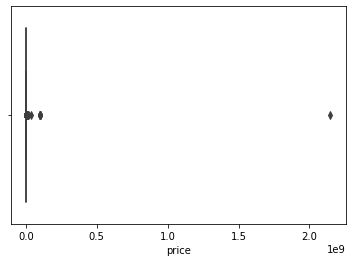

In [16]:
sns.boxplot(x = train['price'])

According to AutoBild (german car magazine) there are no 'normal' (serial production) cars above 200'000 euros. So let's remove them first.

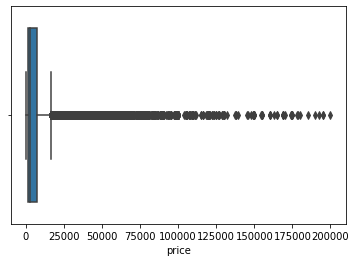

In [17]:
#remove unrealistic values
train = train.loc[train['price'] < 200000]
sns.boxplot(x = train['price'])

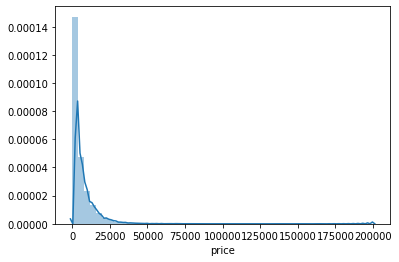

In [18]:
sns.distplot(train['price'])

Looks already better.
But as mentioned in the kaggle notebook https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition
ml models can't handle not normal distributions. A way to shape the distribution is to adapt a log function to the data.

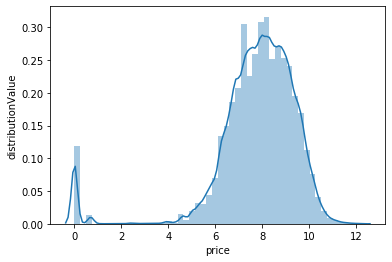

In [19]:
#Check the distribution in a logarithmic scale
sns.distplot(np.log1p(train["price"])).set_ylabel("distributionValue");

It seems to work. But after we tested it out the change of `price` to a logarithmic scale doesn't affect the score so **we let the `price` feature as it is** for better understanding.

---

**Age**

We create a new feature called `age` to substitute the `yearOfRegistration` and `dateCrawled` features. It's more understandable and more consistent to new data.

The pandas function `.to_datetime` can be used that the model understands the focused number as a date. So we can calculate the age. 

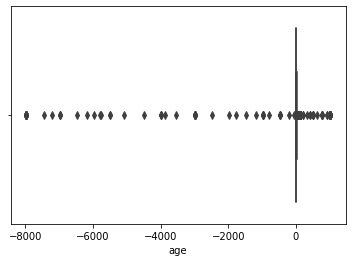

In [20]:
#convert 'dateCrawled' to the datetime feature
train['dateCrawled'] = pd.to_datetime(train['dateCrawled'])
#create the new 'age' feature by calculate the year of 'dateCrawled' minus 'yearOfRegistration'
train['age'] = train['dateCrawled'].dt.year - train['yearOfRegistration']
#print out the boxplot of age
sns.boxplot(x = train['age'])

As we can see there are crazy numbers for age. This is because the `yearOfRegistration` feature is really messy. We want to remove these nonsense values!

Because "Back to the Future" is a SciFi movie, the year of registration can't be in the future for a second hand car . So we want to cut away these cars.

According to [Wikipedia](https://en.wikipedia.org/wiki/Car#Mass_production "Wikipedia"), the mass production of cars started in 1901. So we want to  throw away at least all cars which are older than that.

---

<div>
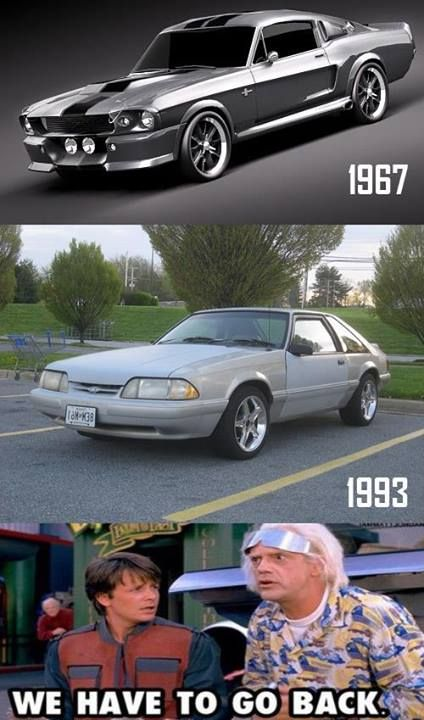
</div>

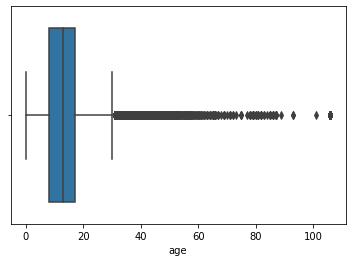

In [21]:
#remove nonsense values
#throw away all cars with 'yearOfRegistration' before 1901
train = train.loc[train['yearOfRegistration'] > 1901]
#drop 'yearOfRegistration because' this feature is now represented by 'age'
train.drop(['yearOfRegistration'], axis=1, inplace = True)
#throw away all cars with 'yearOfRegistration' in the future
train = train.loc[train['age']  >= 0]
sns.boxplot(x = train['age'])

We first removed outliers of the new feature `age` with our beautiful function. But after calculating the RMSE we realized that the score was getting worse, so we outcommented these lines.

In [22]:
# remove the outliers in 'age'
#train = remove_outliers(train, 'age',0,1)
#sns.distplot(train['age'])

---
**powerPS**

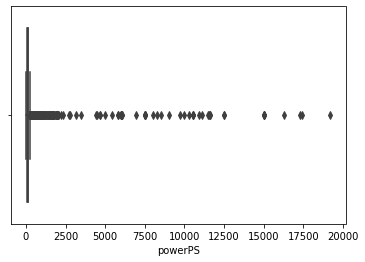

In [23]:
sns.boxplot(x = train['powerPS'])

A quick google search shows, that in 2016 (latest `dateCrawled`) the most powerful production car is the Bugatti Chiron/Sport/Divo with 1500 PS (horse power). So there are a lot of missleading values we want to kick out. 
Because every car above 1000 PS is a crazy sport car, we cut away all cars above 1000 (cut away outliers).

Text(0, 0.5, 'distributionValue')

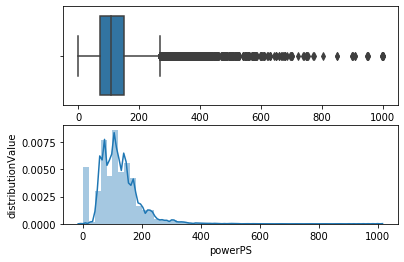

In [24]:
#remove nonsense values
train = train.loc[train['powerPS'] <= 1000]
plt.subplot(2,1,1)
sns.boxplot(x = train['powerPS'])
plt.subplot(2,1,2)
sns.distplot(train['powerPS']).set_ylabel("distributionValue")

---
**kilometer**

Text(0, 0.5, 'distributionValue')

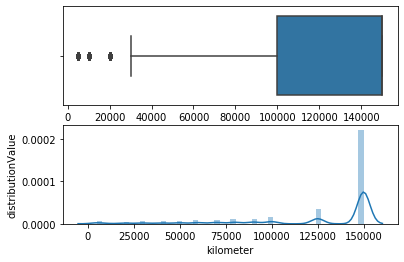

In [25]:
plt.subplot(2,1,1)
sns.boxplot(x = train['kilometer'])
plt.subplot(2,1,2)
sns.distplot(train['kilometer']).set_ylabel("distributionValue")

Seems we have a boundary for `kilometer` at 150'000. Plus the kilometers are grouped in categories so we treat the feature like a category but leave the values numeric.

In [26]:
(((train.loc[train['kilometer']  == 150000].shape[0])/train.shape[0]))

0.6453314143764047

Thats a problem. Half of the training data has a kilometer value of 150000. Let's have a look how it behaves for the test set.

(Text(0, 0.5, 'distributionValue'), 150000)

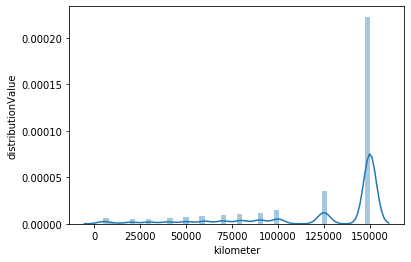

In [27]:
sns.distplot(train['kilometer'], axlabel="kilometer").set_ylabel("distributionValue"), train['kilometer'].max()

The distribution of train and test set look similar. Still the data looks more categorical than numeric.
One idea is to create categories for the kilometer feature. So we did. We choose the range of 12 categories to cluster the amount of kilometer of each car in, but the **RMSE downgrades**. Hence, we removed this step and let the kilometer as they are in the initial datsset.

---
**name_len**

In a kaggle forum discussion about the dataset, someone had the idea to create a feature for the lengt of the name string. So we can get a benefit out of the name feature.

_**Important**_
We right now safe the trainset as `trainset`. The reason for this is, that during the process to optimize the score, we did several possible approaches. The following steps, commands, and changes will not change the actual trainset, because we will reload the set afterwards again. 

In [28]:
#safe data as .csv file
train.to_csv(datapath/'trainset.csv', index = False)

Now the set is saved. When we reload the `trainset` following changes will not be adapted, due to bad influence of the models performance.

In [29]:
#create the 'name_len' feature
train['name_len'] = train['name'].str.len()

4 67


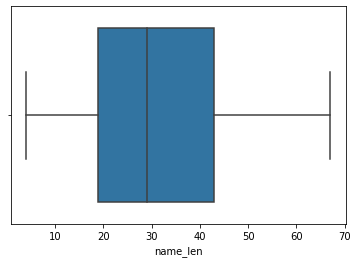

In [30]:
#remove outliers
train = remove_outliers(train, 'name_len',0,0.99999)
sns.boxplot(x=train['name_len'])

---
**postal code**

The data seems to be from Germany (crawled from eBay Kleinanzeigen which is a German website). Maybe we can get more information out of the postal code.

According to wikipedia the German postal code has 5 digits. Let's check on that.

In [31]:
train.loc[train['postalCode']  < 9999].shape[0], train.loc[train['postalCode']  > 9999].shape[0],train.loc[train['postalCode']  > 99999].shape[0]

(10215, 192659, 0)

10'000 instances (~5%) have a postal code which doesn't suit the German system. Let's check if there is a systematic error (e.g. all have the same number)

Text(0, 0.5, 'distributionValue')

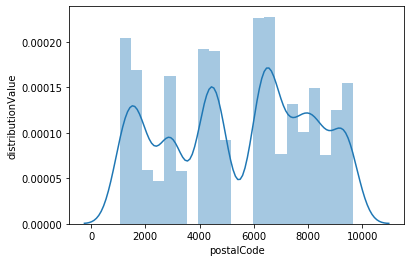

In [32]:
sns.distplot(train.loc[train['postalCode']  < 9999]['postalCode']).set_ylabel("distributionValue")

Seems not to be the case. The Postal codes which not suit the German system are random distributed. An explenation for this could be that the unfitting cars are sold on the website but the seller lives in an other German speaking country (Switzerland or Austria) where the postal code system has 4 digits.
Another possibility are exceptions in the system ([Exceptions on Wikipedia](https://de.wikipedia.org/wiki/Postleitzahl_(Deutschland)#Sonderregelungen "Wikipedia")). As described threre are a few places which have because of several reasons a four digit postal code.
Unfortunately we can't figure out from which country they are really from, if the unfitting cars are all based in locations which are an exception or if the data is just wrong.

Nevertheless, it looks like we could actually place most of the postal codes to coordinates. So let's get into it.

We load a dataset which has the geocordinates for each postal code (source: https://public.opendatasoft.com/explore/dataset/postleitzahlen-deutschland/export/).

In [33]:
#load the geodata to a new dataframe
geodata = pd.read_csv(datapath/'postleitzahlen_deutschland.csv')

#check the data
geodata.head(3)

,Geo Point,Ortsname,Postleitzahl
0,"50.1887724285,8.5159547242",Kronberg im Taunus,61476
1,"48.2017434124,8.5841525734",Villingendorf,78667
2,"48.7639748523,11.2325978452",Bergheim,86673


In [34]:
#check if the the exceptions we mentioned above are in the dataset
geodata.loc[geodata['Postleitzahl'] < 9999].head(3)

,Geo Point,Ortsname,Postleitzahl
5,"51.3445565996,12.4079946628",Leipzig,4315
25,"51.0568350909,12.6851018134",Geithain,4643
26,"51.0740837913,13.035762499",Waldheim,4736


As we can see the dataset contains the exceptions. So let's just try if we can merge the postal codes on our cars. If we have an error it's not that of a problem because all would contain the same error.

In [35]:
#rename the columns according to our train dataset
geodata.rename(columns={"Geo Point": "GeoPoint", "Postleitzahl": "postalCode"}, inplace=True)
#we don't need of the name of the municipality so lets drop it
geodata.drop('Ortsname',axis = 1, inplace = True)

#check if the changes are correct
geodata.head(1)

,GeoPoint,postalCode
0,"50.1887724285,8.5159547242",61476


In [36]:
geodata.shape

(8699, 2)

Now we are ready to merge the two frames. We want to add the `GeoPoint` columns where ever the `postalCode` matches.

In [37]:
#before we merge we want to check if geodata only contains unique postal codes
geodata.nunique()

GeoPoint      8697
postalCode    8181
dtype: int64

In [38]:
#to use postal code as an index we need to drop dublicates
geodata.drop_duplicates('postalCode', inplace = True)

In [39]:
#merge the frames (for 'GeoPoint' a new column is created)
train_merged = pd.merge(train, geodata, how="left", on="postalCode")
#check if it worked
train_merged.head(1)

,carId,dateCrawled,name,seller,offerType,abtest,vehicleType,gearbox,powerPS,model,...,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen,price,age,name_len,GeoPoint
0,209178,2016-04-03 13:56:55,Mercedes_Benz_C_200_T_Kompressor,privat,Angebot,control,kombi,manuell,163,c_klasse,...,mercedes_benz,nein,2016-04-03 00:00:00,0,90455,2016-04-05 12:46:54,6700,11,32,"49.3672574933,11.0831227818"


Remember the 4 digit postal codes in the train set we need to check if there are some unfitting cars (null value in `GeoPoint`).

In [40]:
#check for null values
train_merged['GeoPoint'].isnull().sum()

218

For 218 columns there was not a matching postal code in the `geodata` frame. Let's just drop them.

In [41]:
#drop null values in 'GeoPoint'
train_merged.dropna(axis=0, subset = ['GeoPoint'], inplace = True)
train_merged['GeoPoint'].isnull().sum()

0

As we can see, we just got rid of 218 cars in our trainset by kicking out all cars with no geopoint.
To gain information we need to split up `Latitude` and `Longitude`.

In [42]:
#split Latitude and Longitude
train_merged['Latitude'] = train_merged.GeoPoint.str.split(',').str[0].astype(float)
train_merged['Longitude'] = train_merged.GeoPoint.str.split(',').str[1].astype(float)
#drop GeoPoint (the information is now in the nwe columns)
train_merged.drop('GeoPoint',axis = 1, inplace = True)
#check if it worked
train_merged.head(1)

,carId,dateCrawled,name,seller,offerType,abtest,vehicleType,gearbox,powerPS,model,...,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen,price,age,name_len,Latitude,Longitude
0,209178,2016-04-03 13:56:55,Mercedes_Benz_C_200_T_Kompressor,privat,Angebot,control,kombi,manuell,163,c_klasse,...,nein,2016-04-03 00:00:00,0,90455,2016-04-05 12:46:54,6700,11,32,49.367257,11.083123


---
**Map**

To gain more information we want to print out the cars and their  price on a map of Germany.
For this we need the `geopandas library`.
The map to print on is a shapefile we downloaded on the same site like the table with the postal codes.

>**Copyright:** The following concept of using geopandas to print out a price map and a lot of the code is adapted from this blog: https://medium.com/@ianforrest11/graphing-latitudes-and-longitudes-on-a-map-bf64d5fca391

In [43]:
#uncoment the following if you havent installed geopandas and descartes
#!pip install geopandas
#!pip install descartes

In [44]:
# import libraries
import geopandas as gpd # could be possible that you first have to install geopandas as <pip install geopandas>
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

# import street map
map_germany = gpd.read_file(datapath/'Map/postleitzahlen_deutschland.shp')

In [56]:
#create a GeoDataFrame
gdf = gpd.GeoDataFrame(train_merged, geometry=gpd.points_from_xy(train_merged.Longitude, train_merged.Latitude))
gdf.head(1)

,carId,dateCrawled,name,seller,offerType,abtest,vehicleType,gearbox,powerPS,model,...,dateCreated,nrOfPictures,postalCode,lastSeen,price,age,name_len,Latitude,Longitude,geometry
0,209178,2016-04-03 13:56:55,Mercedes_Benz_C_200_T_Kompressor,privat,Angebot,control,kombi,manuell,163,c_klasse,...,2016-04-03 00:00:00,0,90455,2016-04-05 12:46:54,6700,11,32,49.367257,11.083123,POINT (11.08312 49.36726)


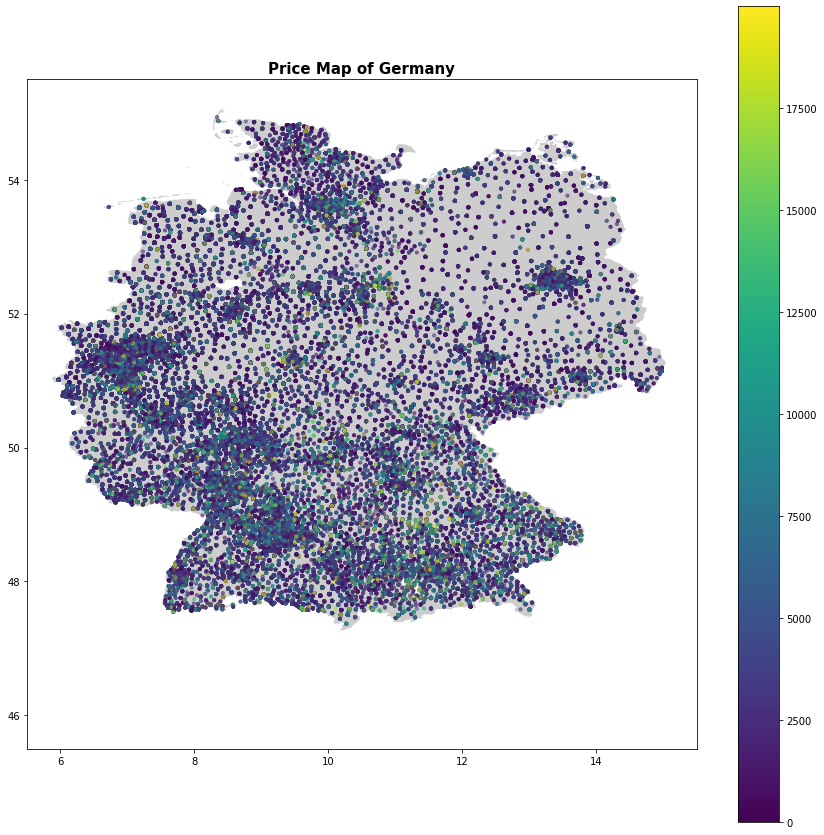

In [57]:
#most of the cars are below 20'000; to gain information we will plot only these (else the scale is too large)
gdf = gdf.loc[gdf['price'] < 20000]

 #create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(15,15))

 #add .shp mapfile to axes
map_germany.plot(ax=ax, alpha=0.4,color='grey')

 #add geodataframe to axes;
 #assign ‘price’ variable to represent coordinates on graph;
 #make datapoints transparent using alpha;
 #add legend;
 #assign size of points using markersize
gdf.plot(column=gdf['price'],ax=ax, alpha=0.5, legend=True, markersize=10)
 #add title to graph
plt.title('Price Map of Germany', fontsize=15,fontweight='bold')

 #set latitude and longitude boundaries for map display
plt.xlim(5.5,15.5)
plt.ylim(45.5,55.5)

 #show map
plt.show()

In [58]:
gdf.shape

(192911, 25)

We can clearly detect the german cities in the map (Berlin on top right). Also we can say that there are more cars in the south-west than in the east.
Also there are more expensive cars in the south (around Munich).

**Sadly it turned out that adding the latitude and longitude makes the score worse**. Maybe because postal codes already divides the cars in german federal states which might be also influence the price (e.g. when people filter the website on cars in the own federal state).
So we will continue with the train file without the merged latitude and longitude.

---

**Reloading**
As said before, we now reload the data, so that nothing above is included in the `trainset`

In [47]:
#load dataset
train = pd.read_csv(datapath/'trainset.csv')

### Explore Categories

In [48]:
train.groupby('seller')['carId'].nunique(), train.seller.unique()

(seller
 gewerblich         2
 privat        202886
 Name: carId, dtype: int64,
 array(['privat', 'gewerblich'], dtype=object))

The cars in our trainset are mostly, except three cars, offerd by privat individuals. Therefore, the category `seller` would disturb our prediction. Before we drop it, we did a pre-test and indeed, the __RMSE is a little bit better without the column `seller`.__ Therefore, we now drop this category.



In [49]:
train = train[train.seller != 'gewerblich']
train.drop(['seller'], axis=1, inplace = True)

We now dropped the whole column `seller`, as we know that it is not representative and would disturb our predictions. 

---

In [50]:
train.groupby('offerType')['carId'].nunique()

offerType
Angebot    202879
Gesuch          7
Name: carId, dtype: int64

We want to make predictions for the price. Therefore, all `offerTypes 'Gesuch'` are not relevant for our model. Furthermore, there are just a tiny amount of 'Gesuch' in our datasets. Therefore, we firstly drop all cars with `offerType = Gesuch`. 

In [51]:
train = train[train.offerType != 'Gesuch']

Secondly, we have to ged rid of the whole column `offerType`, because it is little useful for our purpose`

In [52]:
train.drop(['offerType'], axis=1, inplace = True)

The `offerType` coloumn is now dropped out of our trainset. 

---
**Same problem different feature**
We thought that the internal feature of eBay has no correlation and therefore no influence on the score at the end. Hence, we initially dropped it. But that was a mistakee. The `abtest`feature has a positive inpact on the score, therefore we leave it as it is.

## Data Preprocessing

### Fill Missing Values

There are two approaches for filling in missing values. We are using the `.mode`method. Initially we filled missing values with the kNN (k-nearest-neighbour) method. But after checking the score, we were disappointed. The score increased pretty much. Since the kNN-method needs to have only numerical values, you can see the procedure we've been trough later.

In [53]:
#save the df with missing values for later
train_with_missing = train.copy()

In [54]:
train['vehicleType'].fillna(train['vehicleType'].mode()[0], inplace=True)
train['gearbox'].fillna(train['gearbox'].mode()[0], inplace=True)
train['model'].fillna(train['model'].mode()[0], inplace=True)
train['fuelType'].fillna(train['fuelType'].mode()[0], inplace=True)
train['notRepairedDamage'].fillna(train['notRepairedDamage'].mode()[0], inplace=True)
train.isnull().sum()

carId                  0
dateCrawled            0
name                   0
abtest                 0
vehicleType            0
gearbox                0
powerPS                0
model                  0
kilometer              0
monthOfRegistration    0
fuelType               0
brand                  0
notRepairedDamage      0
dateCreated            0
nrOfPictures           0
postalCode             0
lastSeen               0
price                  0
age                    0
dtype: int64

### Convert Categories

> **Note:** In converting categorical to numeric the Null values change to 0 because in the conversion Null turns into -1 and then we calculate the categorical value +1. 
Means: Null --> -1 --> 0

In [55]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202879 entries, 0 to 202887
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   carId                202879 non-null  int64 
 1   dateCrawled          202879 non-null  object
 2   name                 202879 non-null  object
 3   abtest               202879 non-null  object
 4   vehicleType          202879 non-null  object
 5   gearbox              202879 non-null  object
 6   powerPS              202879 non-null  int64 
 7   model                202879 non-null  object
 8   kilometer            202879 non-null  int64 
 9   monthOfRegistration  202879 non-null  int64 
 10  fuelType             202879 non-null  object
 11  brand                202879 non-null  object
 12  notRepairedDamage    202879 non-null  object
 13  dateCreated          202879 non-null  object
 14  nrOfPictures         202879 non-null  int64 
 15  postalCode           202879 non-nu

Now we want to convert the object dtype columns into categorical and later in numeric.

In [56]:
def convert_strings_to_categories_train(df):
    """
        A function to convert all object columns of a dataframe with the Dtype 'object' into 'category' Dtype.
        The function creates variables in which the category order of the train dataset
        (which are needed in the 'convert_strings_to_categories_test' function) is saved for later.
        
    """
    for c in df:
        if df[c].dtype == 'object':
            df[c] = df[c].astype('category')
            name_temp = str("cat_"+c)
            globals()[name_temp] = df[c].cat.categories
            print(name_temp)

In [57]:
convert_strings_to_categories_train(train)

cat_dateCrawled
cat_name
cat_abtest
cat_vehicleType
cat_gearbox
cat_model
cat_fuelType
cat_brand
cat_notRepairedDamage
cat_dateCreated
cat_lastSeen


In [58]:
def convert_categories_to_numeric(df):
    """
        A function to convert all object columns of a dataframe with the Dtype 'category'
        into a numeric Dtype (based on the category codes).
        
    
    """
    for c in df:
        if df[c].dtype.name == 'category':
            df[c] = df[c].cat.codes + 1

In [59]:
convert_categories_to_numeric(train)

In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202879 entries, 0 to 202887
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   carId                202879 non-null  int64
 1   dateCrawled          202879 non-null  int32
 2   name                 202879 non-null  int32
 3   abtest               202879 non-null  int8 
 4   vehicleType          202879 non-null  int8 
 5   gearbox              202879 non-null  int8 
 6   powerPS              202879 non-null  int64
 7   model                202879 non-null  int16
 8   kilometer            202879 non-null  int64
 9   monthOfRegistration  202879 non-null  int64
 10  fuelType             202879 non-null  int8 
 11  brand                202879 non-null  int8 
 12  notRepairedDamage    202879 non-null  int8 
 13  dateCreated          202879 non-null  int8 
 14  nrOfPictures         202879 non-null  int64
 15  postalCode           202879 non-null  int64
 16  la

## kNN Show Off

As said above we were using the kNN-method to fill in missing values in all datasets (train, valid, test). Since we know, that this is worse than the `.mode`method, we do not adapt these changes. Therefore again, save the `trainset`and then reload it.

In [61]:
#safe data as .csv file
train.to_csv(datapath/'trainset2.csv', index = False)

In [62]:
#overwrite the trainset to train with missing
train = train_with_missing.copy()

#make the columns numerical again
convert_strings_to_categories_train(train)
convert_categories_to_numeric(train)

cat_dateCrawled
cat_name
cat_abtest
cat_vehicleType
cat_gearbox
cat_model
cat_fuelType
cat_brand
cat_notRepairedDamage
cat_dateCreated
cat_lastSeen


---
>Note: We are going to use the K-Nearest Neighbour Method which is **not** adapted to our trainset

Steps:
- Devide the Dataset into train_missing_ColName and train_no_missing_ColName
- Then we scale, fit and transform the train_no_missing_ColName using StandardScaler
- Creating kNN-Model, looking for the 5 nearest neighbors (by default nearest neighbor = 5)
- Making predictions based on the train_no_missing_ColName
- Fill predictions into train_missing_ColName as integers

Following codes show all the steps above for every feature the dataset includes missing values.

- VehicleType
- gearbox
- model
- fuelType
- notRepairedDamage
---

>**Note:** As explained before, missing values are at this state 0 (because -1 in categorical and (-1)+1=0)

In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

def impute_train(target_column):
    """
    This function imputes missing values in the train set (only for categorical data) by using the knn method.
    
    Args:
    target_column: string of a column name in the train df (str)
    
    """
    
    #split the df in two (one with all null values in target_column and one without)
    train_no_missing = train.loc[train[target_column] != 0] # all rows with given value
    train_missing = train.loc[train[target_column] == 0] # all rows with no given value

    #create a list with for the feature matrix
    X_columns = list(train.columns)
    X_columns.remove(target_column)
    
    #creat feature matrix and target vector
    X = train_no_missing[X_columns].dropna()
    y = train_no_missing[target_column]
    
    #to build up the multi dimensional space to perfom knn we have to scale the dimensions (columns)
    #the scaler from sklearn scales down the values to the same range (-1 - 1)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    train_missing = scaler.fit_transform(train_missing[X_columns])

    #Create the knn model.
    #Look at the five closest neighbors.
    knn = KNeighborsRegressor(n_neighbors=5)
    #Fit the model on the training data.
    knn.fit(X,y)
    #Make point predictions on the test set using the fitted model.
    predictions = knn.predict(train_missing)
    #replace the null values in the train set with the predictions
    train.loc[train[target_column] == 0,target_column]= predictions.astype(int)

Now we can apply the function to all columns with null values (look above).

>**Nice to know**: Since we already used the `.mode`method, the function `impute_train` wouldn't work with the filled train set, because there are no missing values anymore.

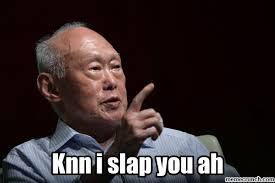

In [64]:
#apply the function to the columns
impute_train('vehicleType')
impute_train('gearbox')
impute_train('model')
impute_train('fuelType')
impute_train('notRepairedDamage')

In [65]:
#check if all null values are filled
print(min(train['vehicleType']))
print(min(train['gearbox']))
print(min(train['model']))
print(min(train['fuelType']))
print(min(train['notRepairedDamage']))

1
1
1
1
1


As we said, now reloading the saved dataset, that the kNN imputations above will not affect our models performance!

In [66]:
#load dataset
train = pd.read_csv(datapath/'trainset2.csv')

### Correlations

We now want to see correlations of the different attributes. What is of most interest are the correlations with price, of course. Because in the end we are going to predict the price.

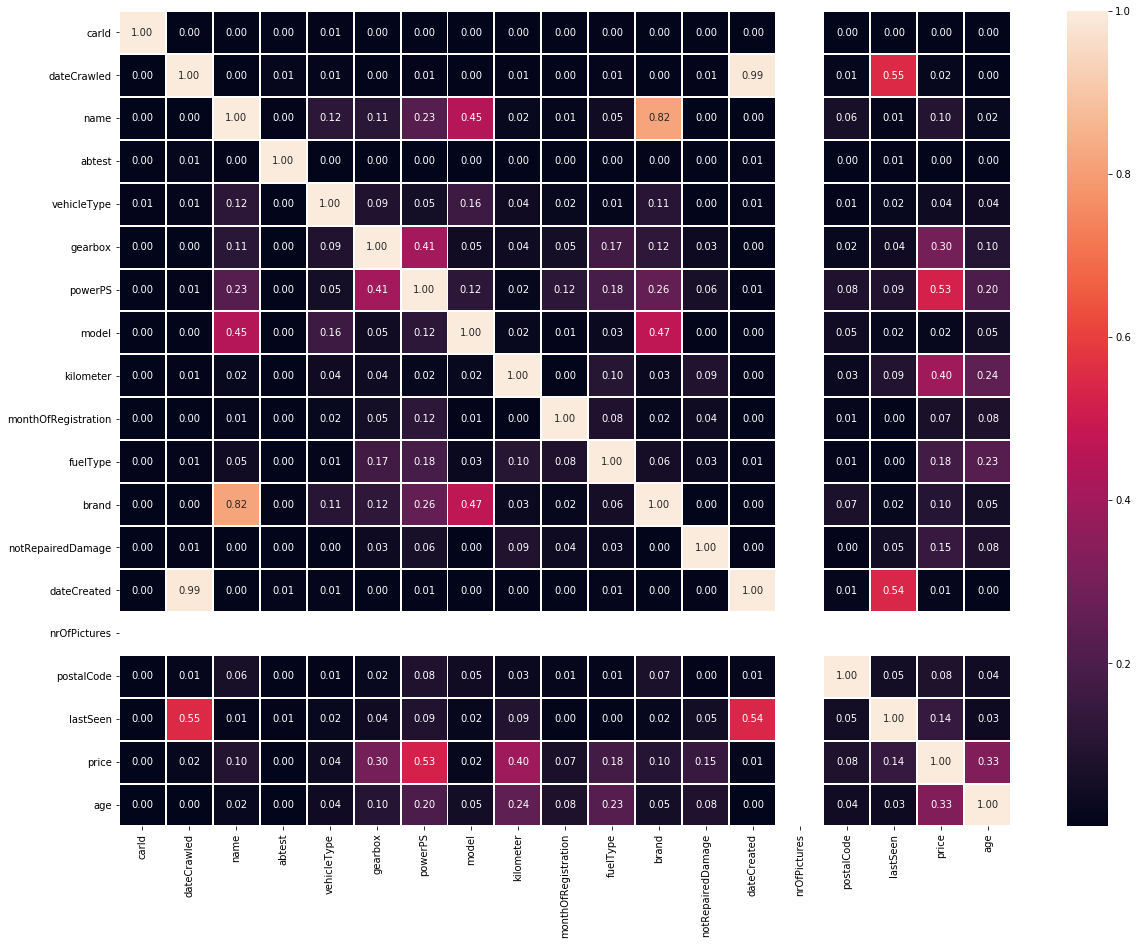

In [67]:
correlation_matrix = train.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(abs(correlation_matrix), annot=True, fmt='.2f', linewidths=1);


The correlation matrix is massively useful. It shows correlations between each feature within the dataset. Hence, We will drop the features which are really redundant (according to our logic and/or the correlation matrix) and then look again at the matrix.

>**Important:** A correlation matrix doesn't show all dependencies between two features! To have a better insight one approach is to plot out the dependency and visually detect patterns.

In [68]:
#drop the columns we think are redundant
train.drop(['dateCrawled'], axis=1, inplace = True)
train.drop(['carId'], axis=1, inplace = True)
train.drop(['name'], axis=1, inplace = True)
train.drop(['dateCreated'], axis=1, inplace = True)
train.drop(['lastSeen'], axis=1, inplace = True)
train.drop(['nrOfPictures'], axis=1, inplace = True)
train.drop(['abtest'], axis=1, inplace = True)

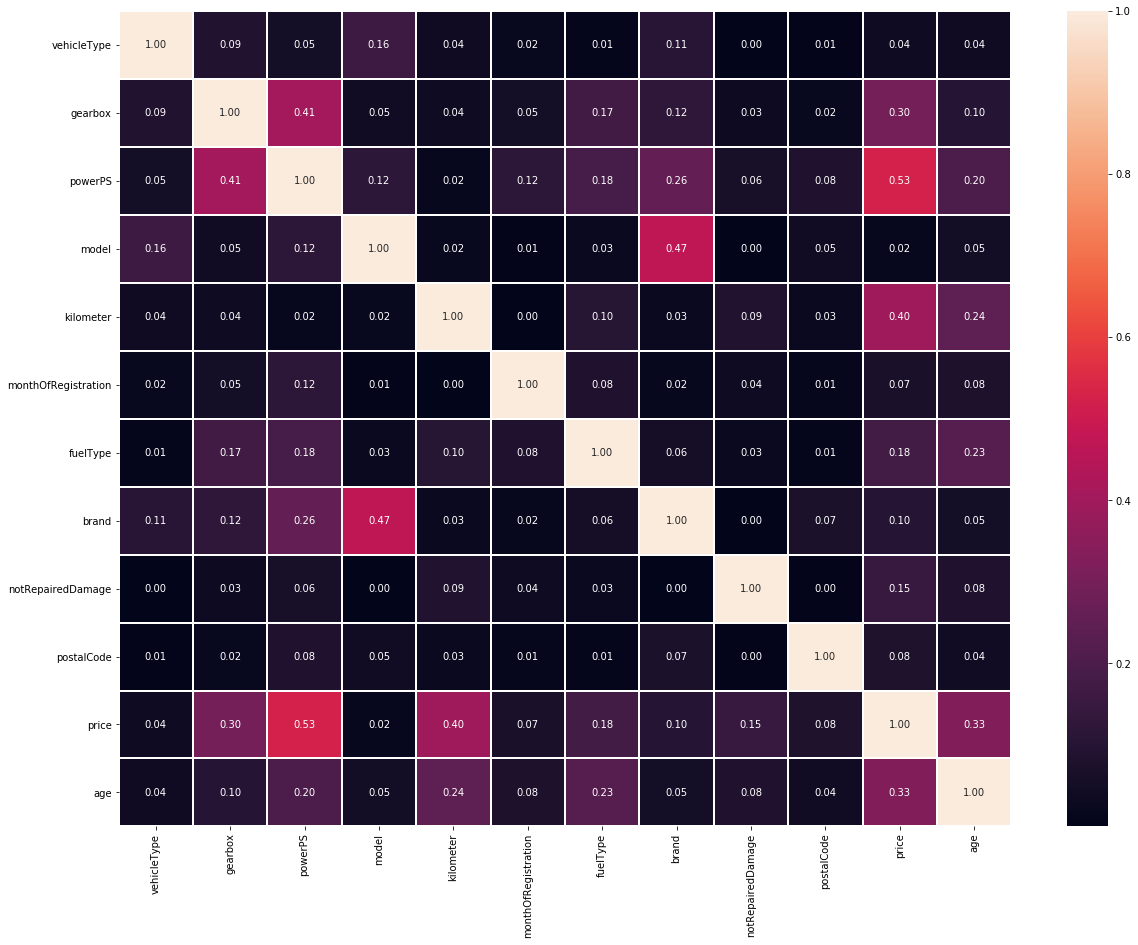

In [69]:
#generate a correlation matrix
correlation_matrix = train.corr()
#set the plotsize
plt.subplots(figsize=(20,15))
#create the heatmap plot with the correlation matrix data
sns.heatmap(abs(correlation_matrix), annot=True, fmt='.2f', linewidths=1);

We can see that the features `price, age, powerPS` and `kilometer` have the strongest correlation with `price`. So let's have a deeper look.

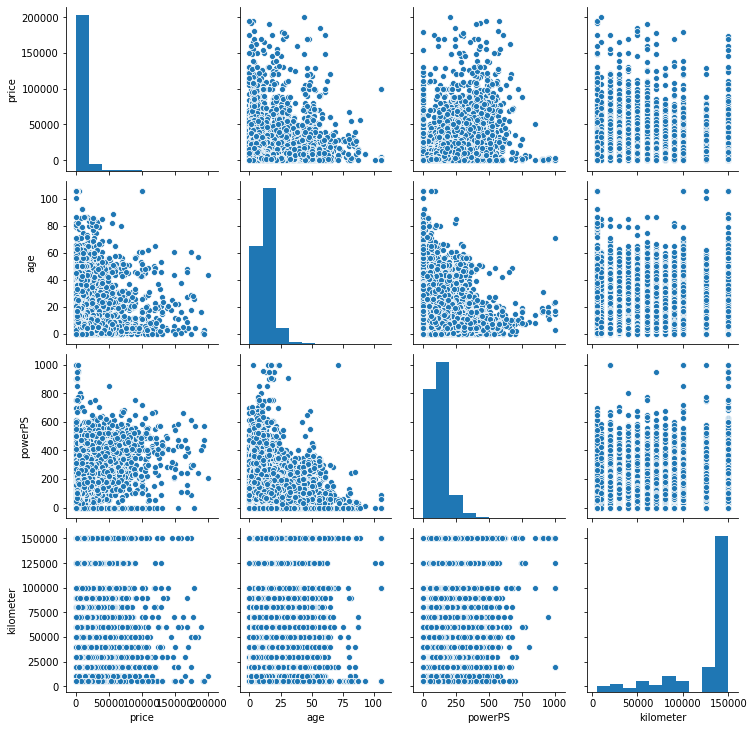

In [70]:
#generate a pairplot for the most interesting (most correlated) features
attributes = ["price", "age", "powerPS", "kilometer"]
sns.pairplot(train[attributes].dropna());

As we can see the distribution of age and powerPS are somehow non-linear and not random. Lets have a deeper look

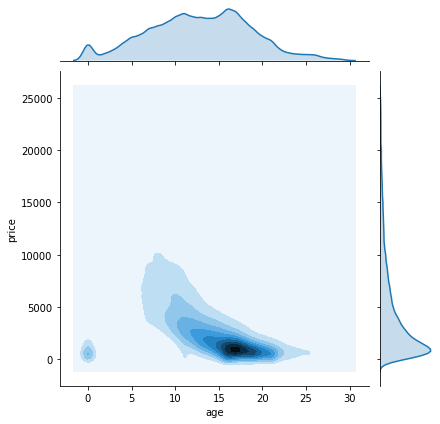

In [71]:
#have a look at the correlation of 'price' and 'age' (for better understanding we cut away the high prices)
sns.jointplot('age', 'price', data=train.loc[(train['price'] < 25000 ) & (train['age'] < 30)], kind='kde');

We can see that most of the cars are between 10 and 25 years old and cost less than 5000.
There is a non linear relationship from top left to bottom right.

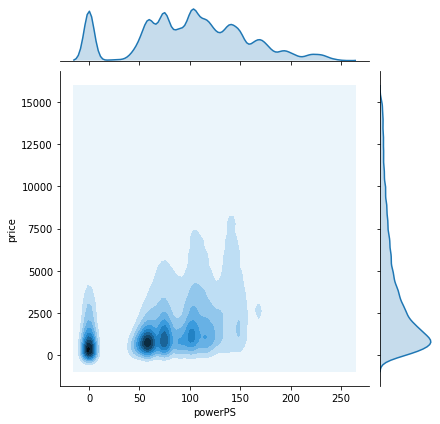

In [72]:
#have a look at the correlation of 'price' and 'powerPS'

sns.jointplot('powerPS', 'price', data=train.loc[(train['price'] < 15000 ) & (train['powerPS'] < 250)], kind = 'kde')

In 'powerPS' we can see a slight linear correlaton from left-bottom to right-top.

### Control & Save Processed Data

In [73]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202879 entries, 0 to 202878
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   vehicleType          202879 non-null  int64
 1   gearbox              202879 non-null  int64
 2   powerPS              202879 non-null  int64
 3   model                202879 non-null  int64
 4   kilometer            202879 non-null  int64
 5   monthOfRegistration  202879 non-null  int64
 6   fuelType             202879 non-null  int64
 7   brand                202879 non-null  int64
 8   notRepairedDamage    202879 non-null  int64
 9   postalCode           202879 non-null  int64
 10  price                202879 non-null  int64
 11  age                  202879 non-null  int64
dtypes: int64(12)
memory usage: 18.6 MB


As we can see, our `traindata` has now not only no missing values, they are all numerical as well. So we safe this train set as `train_final.csv`so that we can easily use it in later steps.

In [74]:
#safe processed data as .csv file
train.to_csv(datapath/'train_final.csv', index = False)

## Validation Set

As right at the beginning mentioned, we splitted the `trainset` into `trainset`and `validset`so that we now can treat the `validset` as the `testset`. 

Since for evaluaten, all sets must have the same features, we now implement above new created or renamed features for the `validset`. Therefore, we waive much detailed explaination of each steps.

In [75]:
valid = pd.read_csv(datapath/'valid1.csv')

In [76]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37339 entries, 0 to 37338
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   carId                37339 non-null  int64 
 1   dateCrawled          37339 non-null  object
 2   name                 37339 non-null  object
 3   seller               37339 non-null  object
 4   offerType            37339 non-null  object
 5   abtest               37339 non-null  object
 6   vehicleType          33452 non-null  object
 7   yearOfRegistration   37339 non-null  int64 
 8   gearbox              35253 non-null  object
 9   powerPS              37339 non-null  int64 
 10  model                35306 non-null  object
 11  kilometer            37339 non-null  int64 
 12  monthOfRegistration  37339 non-null  int64 
 13  fuelType             33939 non-null  object
 14  brand                37339 non-null  object
 15  notRepairedDamage    29964 non-null  object
 16  date

In [77]:
valid = valid.loc[valid['price'] < 200000]

In [78]:
# create the age feature
valid['dateCrawled'] = pd.to_datetime(valid['dateCrawled'])
valid['age'] = valid['dateCrawled'].dt.year - valid['yearOfRegistration']
valid = valid.loc[valid['yearOfRegistration'] > 1901]
valid.drop(['yearOfRegistration'], axis=1, inplace = True)

In [79]:
#deal with unrealistic value
valid.loc[valid['age'] < 0, "age"]= valid['age'].median()
valid.loc[valid['age'] > 106, "age"]= valid['age'].median()

valid.loc[valid['powerPS'] > 1500, "powerPS"] = valid['powerPS'].median()

In [80]:
#drop same columns we droped in the train set
#valid.drop(['yearOfRegistration'], axis=1, inplace = True)
valid.drop(['seller'], axis=1, inplace = True)
valid.drop(['carId'], axis=1, inplace = True)
valid.drop(['offerType'], axis=1, inplace = True)
valid.drop(['dateCrawled'], axis=1, inplace = True)
valid.drop(['name'], axis=1, inplace = True)
valid.drop(['dateCreated'], axis=1, inplace = True)
valid.drop(['lastSeen'], axis=1, inplace = True)
valid.drop(['nrOfPictures'], axis=1, inplace = True)
valid.drop(['abtest'], axis=1, inplace = True)

In [81]:
 #fill missing values with the same method we used in the train set
valid['vehicleType'].fillna(train['vehicleType'].mode()[0], inplace=True)
valid['gearbox'].fillna(valid['gearbox'].mode()[0], inplace=True)
valid['model'].fillna(train['model'].mode()[0], inplace=True)
valid['fuelType'].fillna(valid['fuelType'].mode()[0],inplace=True)
valid['notRepairedDamage'].fillna(valid['notRepairedDamage'].mode()[0], inplace=True)

In [82]:
valid.isnull().sum()

vehicleType            0
gearbox                0
powerPS                0
model                  0
kilometer              0
monthOfRegistration    0
fuelType               0
brand                  0
notRepairedDamage      0
postalCode             0
price                  0
age                    0
dtype: int64

We got rid of the null values. Now the `validset`is ready to be prepared, so that all feature types are numerical.

In [83]:
def convert_strings_to_categories_test(df):
    """
        A function to convert all object columns of a dataframe with the Dtype 'object' into 'category' Dtype.
        The function calls dictionaries with the category order of the train dataset
        which are created in the 'convert_strings_to_categories_train' function.

    """
    
    for c in df:
        if df[c].dtype == 'object':
            df[c] = df[c].astype('category')
            name_temp = str("cat_"+c)
            df[c].cat.set_categories(globals()[name_temp], ordered=True, inplace=True)
            print(name_temp)

In [84]:
convert_strings_to_categories_test(valid)
convert_categories_to_numeric(valid)

cat_vehicleType
cat_gearbox
cat_model
cat_fuelType
cat_brand
cat_notRepairedDamage


As we can see, our `validset` has now not only no missing values, they are all numerical as well. So we safe this train set as `valid_final.csv`so that we can easily use it in later steps.

In [85]:
#safe processed data as .csv file
valid.to_csv(datapath/'valid_final.csv', index = False)

### One Hot Encoding

One hot encoding can improve the score by eliminating the numerical logic of decision trees. For example in our `fuelType` column. We have 7 types of fuel. In our case these 7 different types are represented by values (1-7). The problem is that the decision trees can get confused because the order of the values have no meaning at all. 
Unlike "real" numeric values by which it has a meaning when two values are near the price of two cars with 700 / 710 PS is more similar than of two cars with 30 / 700 PS.

Long speech short sense: we want to apply one hot encoding to important columns (`gearbox`;`fuelType`; `notRepairedDamage`).

>Note: We won't apply it to all columns because more columns need more computation power.

In [86]:
#load train processed data
train_processed = pd.read_csv(datapath/'train_final.csv')

#load valid processed data
valid_processed = pd.read_csv(datapath/'valid_final.csv')

We first have to change thesde three features `gearbox`,`fuelType`, `notRepairedDamage` back to categorical values, due to the hot encoding.

In [87]:
#create dictionaries out of categorical mappings
dict_gearbox = dict(enumerate(cat_gearbox))
dict_fuelType = dict(enumerate(cat_fuelType))
dict_notRepairedDamage = dict(enumerate(cat_notRepairedDamage))

#replace the numbers with strings
train_processed["gearbox"] = (train_processed["gearbox"]-1).replace(dict_gearbox)
train_processed["fuelType"] = (train_processed["fuelType"]-1).replace(dict_fuelType)
train_processed["notRepairedDamage"] = (train_processed["notRepairedDamage"]-1).replace(dict_notRepairedDamage)

valid_processed["gearbox"] = (valid_processed["gearbox"]-1).replace(dict_gearbox)
valid_processed["fuelType"] = (valid_processed["fuelType"]-1).replace(dict_fuelType)
valid_processed["notRepairedDamage"] = (valid_processed["notRepairedDamage"]-1).replace(dict_notRepairedDamage)

In [88]:
#convert the columns to categories
convert_strings_to_categories_test(train_processed)
convert_strings_to_categories_test(valid_processed)

cat_gearbox
cat_fuelType
cat_notRepairedDamage
cat_gearbox
cat_fuelType
cat_notRepairedDamage


In [89]:
#apply one hot encoding to the corresponding columns
train_processed = pd.get_dummies(train_processed, columns=['gearbox','fuelType','notRepairedDamage'])
valid_processed = pd.get_dummies(valid_processed, columns=['gearbox','fuelType','notRepairedDamage'])

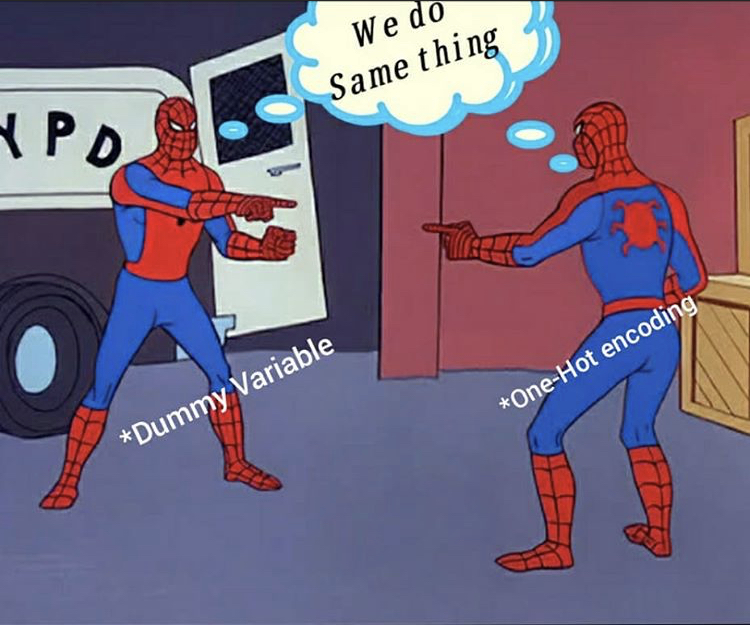

## Build a baseline model (Random Forest)

### Create train and test sets

As we now have learned in the process, we now need to again create the `feature matrix X and the target vector y`. The result after all this preprocessing is much better now.

In [90]:
#create the feature matrix X and the target vector y
X_train = train_processed.drop('price', axis=1)
y_train = train_processed['price']

In [91]:
#create the feature matrix X and the target vector y for the validation set
X_valid = valid_processed.drop('price', axis=1)
y_valid = valid_processed['price']

### Evaluation Metric

As mentioned in the description of the competition the score is evaluated on the [Root-Mean-Squared-Error (RMSE)](https://en.wikipedia.org/wiki/Root-mean-square_deviation "Wikipedia").

$$ \mbox{RMSE} = \sqrt{\frac{1}{m}\sum_{i=1}^m \left(\hat{y}_i - y_i\right)^2}$$

RMSE describes the standard deviation of the predicted values. It has a higher weight on larger errors. Which means the method is more sensitive to outliers.

In [92]:
#function is copied/adapted from Lewis and Leandros Data Science Lectures

def rmse(y, yhat):
    """A utility function to calculate the Root Mean Square Error (RMSE).
    
    Args:
        y (array): Actual values for target.
        yhat (array): Predicted values for target.
        
    Returns:
        rmse (double): The RMSE.
    """
    
    a = np.floor(np.expm1(y))
    b = np.floor(np.expm1(yhat))
    
    return np.sqrt(mean_squared_error(y, yhat))

In [93]:
#function is copied/adapted from Lewis and Leandros Data Science Lectures

def print_rf_scores(fitted_model):
    """Generates RMSE and R^2 scores from fitted Random Forest model."""

    yhat_train = fitted_model.predict(X_train)
    R2_train = fitted_model.score(X_train, y_train)
    yhat_valid = fitted_model.predict(X_valid)
    R2_valid = fitted_model.score(X_valid, y_valid)

    scores = {
        "RMSE on train:": rmse(y_train, yhat_train),
        "R^2 on train:": R2_train,
        "RMSE on valid:": rmse(y_valid, yhat_valid),
        "R^2 on valid:": R2_valid,
    }
    if hasattr(fitted_model, "oob_score_"):
        scores["OOB R^2:"] = fitted_model.oob_score_

    for score_name, score_value in scores.items():
        print(score_name, round(score_value, 3))

### Baseline Model

Our first `RandomForestRegressor`model is not finally created. This model is not optimized, due to no hyperparameter tuning. We just show our first RMSE score.

In [94]:
model = RandomForestRegressor(n_estimators=30, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)
print_rf_scores(model)

RMSE on train: 1384.02
R^2 on train: 0.972
RMSE on valid: 4168.38
R^2 on valid: 0.763


We achieved a RMSE of 4168 without for our simple `RandomForest` Model. Thats not bad (considering the price range of 200'000 in the train set)!
Let's see how far we can go when we choose other models and tune them.

## Set Up Different Models and Hyperparameter Tuning

> 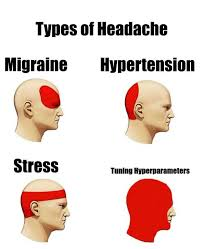

The images speaks for itself...

### Multiple Regressor Analysis

To pick the best model, we compare different regression models (adapted from https://www.kaggle.com/veensk/titanic-multiple-classifier-analysis).
We've just picked a few regressers we stumbled across.

In [95]:
#create a list with different model types
models = [
    RandomForestRegressor(),
    GradientBoostingRegressor(), 
    AdaBoostRegressor(),
    HistGradientBoostingRegressor(),
    xgb.XGBRegressor()
]
log_cols = ["Model", "RMSE"]
log = pd.DataFrame(columns=log_cols)

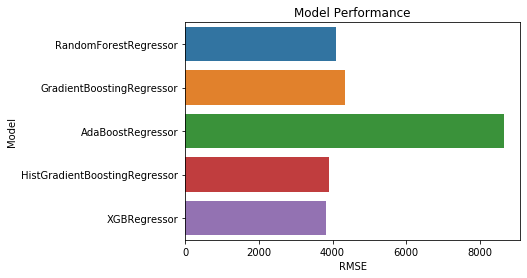

In [96]:
#let every model predict on the validation set and save the RMSE scores in a dictionary
for m in models:
    name = m.__class__.__name__
    m.fit(X_train, y_train)
    train_predictions = m.predict(X_valid)    
    RMSE = rmse(y_valid, train_predictions)
    log = log.append({'Model':name, 'RMSE':RMSE}, ignore_index=True)

#plot out the RMSE scores to compare them
plt.title('Model Performance')
plt.xlabel('RMSE')
sns.set_color_codes("pastel")
sns.barplot(x="RMSE", y="Model", data=log)

The `XGBRegressor` scores the best without optimization. Let's see how far we can go when we tune each of these models. Because we are most familiar with the random forest model we will start with that.

### Random Forest Regressor (Created by Manuel and Simon)

As written bevore, we want to tune the hyperparameters for the `RandomForest` model.
To do so we want to go through each parameter and search for the best possible value. The order of which parameter to tune first matters. 

---
**number of trees**
At first we want to find out when the score of a `RandomForest` model doesn't improve significantly by just adding more trees. This helps in the further process because the time for fitting a model with 30 trees is much shorter than fitting a model with 100 trees. Because of the iterations (in the cells below) we can save hours. ;)

>**Copyright:** The following concept of analyzing each tree is adapted from Lewis and Leandros ds lectures.

In [97]:
#initialize a rf with 100 trees so we can analyze the impact of each additional tree from 1 - 100
model = RandomForestRegressor(n_estimators = 100, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)
print_rf_scores(model)

RMSE on train: 1330.599
R^2 on train: 0.974
RMSE on valid: 4080.883
R^2 on valid: 0.773


In [98]:
#let every tree predict on the validation set
preds = np.stack([tree.predict(X_valid) for tree in model.estimators_])

In [99]:
#initialize a list for the predictions
preds_list = []

#append the r2 score for by append the trees one for one
for tree in model.estimators_:
    preds_list.append(tree.predict(X_valid))

# concatenate list of predictions into single array 
preds_v2 = np.stack(preds_list)

# test that arrays are equal
assert_array_equal(preds, preds_v2)

In [100]:
#generate a plot for the r2 score when we add tree after tree
#this function is adapted from Lewis and Leandros ds lectures
def plot_r2_vs_trees(preds, y_valid):
    """Generate a plot of R^2 score on validation set vs number of trees in Random Forest"""
    fig, ax = plt.subplots()
    plt.plot(
        [
            r2_score(y_valid, np.mean(preds[: i + 1], axis=0))
            for i in range(len(preds) + 1)
        ]
    )
    ax.set_ylabel("$R^2$ on validation set")
    ax.set_xlabel("Number of trees")

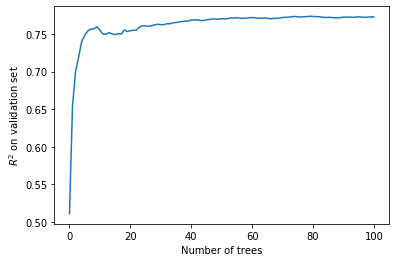

In [101]:
plot_r2_vs_trees(preds, y_valid)

>**Note:** Above 40 trees the R2 value gets only slightly better. So we will work with just **40** estimators for thehyperparameter tuning.

---
**Grid Search**

In [102]:
from sklearn.model_selection import GridSearchCV

# define range of values for each hyperparameter
param_grid = [
    {
        "max_features": [0.05, 0.2, 0.5, 1.0, "sqrt", "log2"],
        "min_samples_leaf": [0.1,0.5,1, 3, 5, 10],
    }
]

# instantiate baseline model
model = RandomForestRegressor(n_estimators=60, n_jobs=-1, random_state=42)

# initialise grid search with cross-validation
grid_search = GridSearchCV(
    model, param_grid=param_grid, cv=3, scoring="neg_root_mean_squared_error", n_jobs=-1)

___
>**!!! Attention:** Uncoment the next cell to perform a grid search but this will take up to several hours computation time. **!!!**

In [103]:
#apply the grid search for the initialized rf model
#%time grid_search.fit(X_train, y_train)

#print(grid_search.best_params_)
#print(grid_search.best_estimator_)
#print_rf_scores(best_model)

___
>**Copyright:** The following concept for analysing hyperparameters is copied from lewis and leandros data science lectures.

#### Best Parameters

In [104]:
rmse_train = []
rmse_valid = []

max_features = [0.05, 0.2, 0.5, 1.0, "sqrt", "log2"]
for f in max_features:
    rf = RandomForestRegressor(n_estimators=40, max_features=f, n_jobs=-1, random_state = 42)
    rf.fit(X_train, y_train)
    yhat_train = rf.predict(X_train)
    yhat_valid = rf.predict(X_valid)
    
    # we append the scores to the list
    rmse_train.append(rmse(y_train, yhat_train))
    rmse_valid.append(rmse(y_valid, yhat_valid))

f_best = max_features[np.argmin(rmse_valid)]
f_best

0.5

In [105]:
rmse_train = []
rmse_valid = []

max_depths = [1, 2, 16, 32, 64, 100, 150]
for d in max_depths:
    rf = RandomForestRegressor(n_estimators=40, max_depth=d, max_features=f_best, n_jobs=-1, random_state = 42)
    rf.fit(X_train, y_train)
    yhat_train = rf.predict(X_train)
    yhat_valid = rf.predict(X_valid)
    
    # we append the scores to the list
    rmse_train.append(rmse(y_train, yhat_train))
    rmse_valid.append(rmse(y_valid, yhat_valid))
    
d_best = max_depths[np.argmin(rmse_valid)]
d_best

16

In [106]:
rmse_train = []
rmse_valid = []

min_samples_leaf = [0.1,0.5,1, 3, 5, 10, 20, 100, 300]
for l in min_samples_leaf:
    rf = RandomForestRegressor(n_estimators=40, max_depth=d_best, max_features=f_best, \
                               min_samples_leaf=l, n_jobs=-1, random_state = 42)
    rf.fit(X_train, y_train)
    yhat_train = rf.predict(X_train)
    yhat_valid = rf.predict(X_valid)
    
    # we append the scores to the list
    rmse_train.append(rmse(y_train, yhat_train))
    rmse_valid.append(rmse(y_valid, yhat_valid))
    
l_best = min_samples_leaf[np.argmin(rmse_valid)]
l_best

1

In [107]:
rmse_train = []
rmse_valid = []

min_samples_split = [2, 3, 4, 10]
for s in min_samples_split:
    rf = RandomForestRegressor(n_estimators=40, max_depth=d_best, max_features=f_best, \
                               min_samples_leaf=l_best, min_samples_split= s, n_jobs=-1, random_state = 42)
    rf.fit(X_train, y_train)
    yhat_train = rf.predict(X_train)
    yhat_valid = rf.predict(X_valid)
    
    # we average the scores and append them to the list
    rmse_train.append(rmse(y_train, yhat_train))
    rmse_valid.append(rmse(y_valid, yhat_valid))
    
s_best = min_samples_split[np.argmin(rmse_valid)]
s_best

2

In [108]:
rmse_train = []
rmse_valid = []

min_impurity_split = [0.5,1,2, 3, 4, 10]
for i in min_impurity_split:
    rf = RandomForestRegressor(n_estimators=40, max_depth=d_best, max_features=f_best, \
                               min_samples_leaf=l_best, min_samples_split= s, n_jobs=-1, random_state = 42,\
                               min_impurity_split=i)
    rf.fit(X_train, y_train)
    yhat_train = rf.predict(X_train)
    yhat_valid = rf.predict(X_valid)
    
    # we average the scores and append them to the list
    rmse_train.append(rmse(y_train, yhat_train))
    rmse_valid.append(rmse(y_valid, yhat_valid))
    
i_best = min_impurity_split[np.argmin(rmse_valid)]
i_best

4

In [109]:
#let the best rf model predict on the validation set
rf = RandomForestRegressor(n_estimators=40, max_depth=d_best, max_features=f_best, \
                               min_samples_leaf=l_best, min_samples_split= s, n_jobs=-1, random_state = 42,\
                               min_impurity_split=i)
rf.fit(X_train, y_train)
print_rf_scores(rf)

RMSE on train: 2549.505
R^2 on train: 0.904
RMSE on valid: 3808.487
R^2 on valid: 0.802


We have improved the RMSE on the validation set by 200.
Let's see how the model improves when we take more estimators.

In [110]:
rf = RandomForestRegressor(n_estimators=300, max_depth=d_best, max_features=f_best, \
                               min_samples_leaf=l_best, min_samples_split= s, n_jobs=-1, random_state = 42,\
                               min_impurity_split=i)
rf.fit(X_train, y_train)
print_rf_scores(rf)

RMSE on train: 2519.229
R^2 on train: 0.906
RMSE on valid: 3768.534
R^2 on valid: 0.806


This gives us another 40. Let's stay with that and check out what's possible with other regression models.

But first we want to save the hyperparameters so we don't have to run the whole thing again.

In [111]:
#print out the best hyperparameters so we can copy this model when we need it.
rf

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=16, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=10, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [112]:
#
rf = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=16, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=10, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
rf.fit(X_train, y_train)
predictionsrf = rf.predict(X_valid)


In [113]:
# create a submission DataFrame
compare_price_rf = pd.DataFrame(columns=['Price', 'Predictions', 'Difference'])
#fill the columns
compare_price_rf['Price'] = y_valid
compare_price_rf['Predictions'] = predictionsrf
compare_price_rf['Difference'] = compare_price_rf['Price'] - compare_price_rf['Predictions']
#check if all worked fine
compare_price_rf.head()

,Price,Predictions,Difference
0,7599,6968.063016,630.936984
1,11999,3164.904797,8834.095203
2,56900,37616.139203,19283.860797
3,3000,4797.154932,-1797.154932
4,1555,1092.929914,462.070086


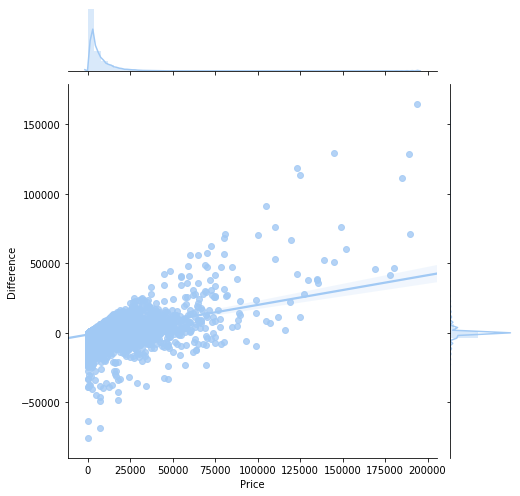

In [114]:
#print out a scatterplot with the real price and the difference to our predictions
sns.jointplot("Price", "Difference", data=compare_price_rf,
                  kind="reg", truncate=False,
                  color="b", height=7)

We can see that our `RandomForest` model predicts bad on higher priced cars. The difference increases linearly compared to the price.
We think that this is because most of the training data is in the lower price region so the model can't train on the higher priced cars.

In [115]:
compare_price_rf["Difference"].describe()

count     37313.000000
mean       -144.775662
std        3765.802460
min      -75655.037886
25%        -933.138321
50%        -201.015452
75%         533.949182
max      164799.724767
Name: Difference, dtype: float64

As we can see, out of more than 37'000 predictions the `RandomForestRegressor`is predicting overall i little bit to much. Therefore, the mean as well as the median is negative. 

### Gradient Boosting Regressor (Created by Manuel)

Another approach to predict values instead of using the `RandomForestRegressor`is the `GradientBoostingRegressor`. The procedure of defining hyperparameters is the same as with the RandomForestRegressor. However, the parameters can be different. 

In [116]:
from sklearn import  ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

In [117]:
from sklearn.model_selection import GridSearchCV

# define range of values for each hyperparameter
param_grid = [
    {
        "learning_rate": [0.05,0.1,0.15,0.5],
        "n_estimators": [16,32,64,100,300],
        "max_features": [0.05, 0.2, 0.5, 1.0, "sqrt", "log2"],
        "min_samples_leaf": [0.1,0.5,1, 3, 5, 10],
        "max_depth": [1,2,3,4,5]
    }
]

# instantiate baseline model
gbr_model = GradientBoostingRegressor(n_estimators=25, random_state=42)

# initialise grid search with cross-validation
grid_search = GridSearchCV(
    gbr_model, param_grid=param_grid, cv=3, scoring="neg_root_mean_squared_error", n_jobs=-1)

The next few codes are part of the `Grid Search`. It optimizes all given parameters with each other so that the regressor will perform the most powerful predictions. 

> **Attention**!! Running the Grid Search command can take hours

In [118]:
#%time grid_search.fit(X_train, y_train)
#print(grid_search.best_params_)

In [119]:
#best_params = grid_search.best_params_
#best_params

In [120]:
#best_model = grid_search.best_estimator_
#best_model
#print_rf_scores(best_model)

---

Another approach to get best values for each parameter is the following procedure. It allows to optimize each parameter step by step. Out of several tests we found out, that some parameters are fitted best with the default value given, such as `max_leaves_nodes`. Therefore, we optimize the following parameters:

   - max_depth
   - learning_rate
   - n_estimators
   - max_features
   - min_samples_split
   - min_samples_leaf
   - min_impurity_split
   
As we've learned, just do one parameter at once and check if the changes positively infliuence the RMSE.

**Tipp** Letting the functions evaluating the best values is taking a lot of time. Therefore, once we were fine with tuning these parameters, we printed the whole GradientBoostingRegressor out, that these parameters were set. (see below)

At first we want to check our RMSE without hyperparameter tuning.

In [121]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
print_rf_scores(gbr)

RMSE on train: 3969.289
R^2 on train: 0.767
RMSE on valid: 4342.516
R^2 on valid: 0.743


___
>**Copyright:** The following concept for analysing hyperparameters is copied from lewis and leandros data science lectures.


In [122]:
rmse_train = []
rmse_valid = []

max_depth= [25,30,35]
for mg in max_depth:
    gbr = GradientBoostingRegressor(max_depth=mg, max_features=1, learning_rate=0.15, \
                               min_samples_leaf=3, random_state = 42)
    gbr.fit(X_train, y_train)
    yhat_train = gbr.predict(X_train)
    yhat_valid = gbr.predict(X_valid)
    
    # we append the scores to the list
    rmse_train.append(rmse(y_train, yhat_train))
    rmse_valid.append(rmse(y_valid, yhat_valid))
    
mg_best = max_depth[np.argmin(rmse_valid)]
mg_best

25

In [123]:
rmse_train = []
rmse_valid = []

learning_rate = [0.001,0.01,0.05]
for lg in learning_rate:
    gbr = GradientBoostingRegressor(max_depth=mg_best, max_features=1, learning_rate=lg, \
                               min_samples_leaf=3, random_state = 42)
    gbr.fit(X_train, y_train)
    yhat_train = gbr.predict(X_train)
    yhat_valid = gbr.predict(X_valid)
    
    # we append the scores to the list
    rmse_train.append(rmse(y_train, yhat_train))
    rmse_valid.append(rmse(y_valid, yhat_valid))
    
lg_best = learning_rate[np.argmin(rmse_valid)]
lg_best

0.05

In [124]:
rmse_train = []
rmse_valid = []

n_estimators=[150,170,200]
for ng in n_estimators:
    gbr = GradientBoostingRegressor(n_estimators=ng, max_depth=mg_best, max_features=1, learning_rate=lg_best, \
                               min_samples_leaf=3, random_state = 42)
    gbr.fit(X_train, y_train)
    yhat_train = gbr.predict(X_train)
    yhat_valid = gbr.predict(X_valid)
    
    # we append the scores to the list
    rmse_train.append(rmse(y_train, yhat_train))
    rmse_valid.append(rmse(y_valid, yhat_valid))
    
ng_best = n_estimators[np.argmin(rmse_valid)]
ng_best

200

In [125]:
rmse_train = []
rmse_valid = []

max_features = [0.05, 0.2, 0.5, 1.0, "sqrt", "log2"]
for fg in max_features:
    gbr = GradientBoostingRegressor(n_estimators=ng_best, max_depth=mg_best, max_features=fg, learning_rate=lg_best, \
                               min_samples_leaf=3, random_state = 42)
    gbr.fit(X_train, y_train)
    yhat_train = gbr.predict(X_train)
    yhat_valid = gbr.predict(X_valid)
    
    # we append the scores to the list
    rmse_train.append(rmse(y_train, yhat_train))
    rmse_valid.append(rmse(y_valid, yhat_valid))
    
fg_best = max_features[np.argmin(rmse_valid)]
fg_best

'sqrt'

In [126]:
rmse_train = []
rmse_valid = []

min_samples_split = [1.0,2,3]
for sg in min_samples_split:
    gbr = GradientBoostingRegressor(n_estimators=ng_best, max_depth=mg_best, max_features=fg_best, learning_rate=lg_best, \
                               min_samples_leaf=3, random_state = 42, min_samples_split=sg)
    gbr.fit(X_train, y_train)
    yhat_train = gbr.predict(X_train)
    yhat_valid = gbr.predict(X_valid)
    
    # we append the scores to the list
    rmse_train.append(rmse(y_train, yhat_train))
    rmse_valid.append(rmse(y_valid, yhat_valid))
    
sg_best = min_samples_split[np.argmin(rmse_valid)]
sg_best

2

In [127]:
rmse_train = []
rmse_valid = []

min_samples_leaf = [5,6,8]
for ming in min_samples_leaf:
    gbr = GradientBoostingRegressor(n_estimators=ng_best, max_depth=mg_best, max_features=fg_best, learning_rate=lg_best, \
                               min_samples_leaf=ming, random_state = 42, min_samples_split=sg_best)
    gbr.fit(X_train, y_train)
    yhat_train = gbr.predict(X_train)
    yhat_valid = gbr.predict(X_valid)
    
    # we append the scores to the list
    rmse_train.append(rmse(y_train, yhat_train))
    rmse_valid.append(rmse(y_valid, yhat_valid))
    
ming_best = min_samples_leaf[np.argmin(rmse_valid)]
ming_best

8

In [128]:
rmse_train = []
rmse_valid = []

min_impurity_split = [0,1]
for ims in min_impurity_split:
    gbr = GradientBoostingRegressor(n_estimators=ng_best, max_depth=mg_best, max_features=fg_best, learning_rate=lg_best, \
                               min_samples_leaf=ming_best, random_state = 42, min_samples_split=sg_best,\
                                    min_impurity_split=ims)
    gbr.fit(X_train, y_train)
    yhat_train = gbr.predict(X_train)
    yhat_valid = gbr.predict(X_valid)
    
    # we append the scores to the list
    rmse_train.append(rmse(y_train, yhat_train))
    rmse_valid.append(rmse(y_valid, yhat_valid))
    
ims_best = min_impurity_split[np.argmin(rmse_valid)]
ims_best

1

In [129]:
#initialize the gbr model
gbr = GradientBoostingRegressor(n_estimators=ng_best, max_depth=mg_best, max_features=fg_best, learning_rate=lg_best, \
                                min_samples_leaf=ming_best, random_state = 42, min_samples_split=sg_best,\
                                min_impurity_split=ims)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls',
                          max_depth=25, max_features='sqrt',
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=1, min_samples_leaf=8,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=200, n_iter_no_change=None,
                          presort='deprecated', random_state=42, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

We achieved a massive improvement with hyperparametertuning (around 780). Which is very cool!! We will see later, that the gbr is the regressor with the lowest RMSE score. Therefore, it is expected, that in the following stacked/blended model the percentage of gbr is higher than other regressors.

In [130]:
#save the parameters for later
gbr

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls',
                          max_depth=25, max_features='sqrt',
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=1, min_samples_leaf=8,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=200, n_iter_no_change=None,
                          presort='deprecated', random_state=42, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

In [131]:
gbr = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls',
                          max_depth=30, max_features='sqrt',
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=1, min_samples_leaf=6,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=200, n_iter_no_change=None,
                          presort='deprecated', random_state=42, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls',
                          max_depth=30, max_features='sqrt',
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=1, min_samples_leaf=6,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=200, n_iter_no_change=None,
                          presort='deprecated', random_state=42, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

In [132]:
predictionsgbr = gbr.predict(X_valid)

In [133]:
# create a submission DataFrame
compare_price_gbr = pd.DataFrame(columns=['Price', 'Predictions', 'Difference'])
#fill the columns
compare_price_gbr['Price'] = y_valid
compare_price_gbr['Predictions'] = predictionsgbr
compare_price_gbr['Difference'] = compare_price_gbr['Price'] - compare_price_gbr['Predictions']
#check if all worked fine
compare_price_gbr.head()

,Price,Predictions,Difference
0,7599,7570.995309,28.004691
1,11999,2869.398586,9129.601414
2,56900,37839.398492,19060.601508
3,3000,4660.230753,-1660.230753
4,1555,1032.102095,522.897905


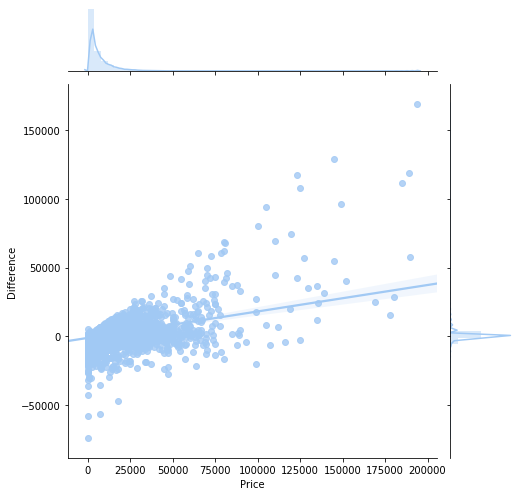

In [136]:
#print out a scatterplot with the real price and the difference to our predictions
sns.jointplot("Price", "Difference", data=compare_price_gbr,
                  kind="reg", truncate=False,
                  color="b", height=7)

In [137]:
compare_price_gbr["Difference"].describe()

count     37313.000000
mean        -94.207836
std        3554.636743
min      -73906.069276
25%        -797.479343
50%        -100.338141
75%         496.924745
max      169191.304995
Name: Difference, dtype: float64

The price difference is in the `GradientBoostingRegressor`less vulnerable on higher prices of cars in the validset. But still the effect is the same as it is in the `RandomForestRegressor`. Also the GBR is predicting in average a higher price than the 'real' price.  

#### Featrure Importance

According to scikit, impurity-based feature importance can be very misleading. Therefore, as they recommend, we are also using besxides `feature_importance`  `permutation_importance`. We use the validset, since we want to know the models feature importance on the testset. Hence, I am a happy guy that we already have created such a validset, which is more similar to the testset than the trainset. 

> **Copyright:** The following code is from: https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html

In [138]:
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance

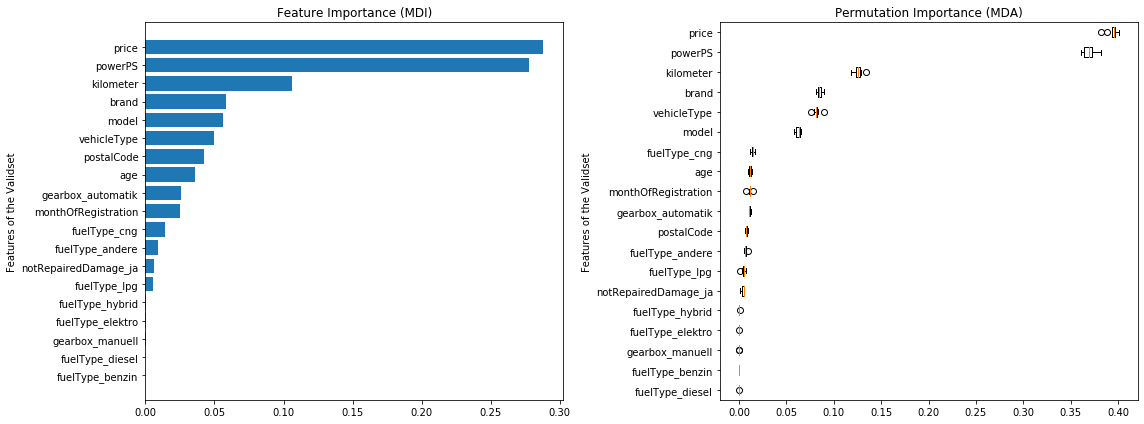

In [139]:
feature_importance = gbr.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(valid_processed.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')
plt.ylabel("Features of the Validset")

result = permutation_importance(gbr, X_valid, y_valid, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(valid_processed.columns)[sorted_idx])
plt.title("Permutation Importance (MDA)")
plt.ylabel("Features of the Validset")
fig.tight_layout()
plt.show()

MDI means `Mean Decrease in Impurity`. MDA means `Mean Decrease in Accuracy`. As it can be seen in the figures above, five most influencable. 


### XGBoost Regression (Created by Simon)

XGBoost is an advanced method of gradient boosting. It runs faster and uses more accurate methods to estimate the best tree model.

In [140]:
#we need to transform the data to a special format (DMatrix) so the xgb regressor can handle the data
D_train = xgb.DMatrix(X_train, label=y_train)
D_valid = xgb.DMatrix(X_valid, label=y_valid)

In [141]:
#set the parameters for the regressor (cause we want a simple model first we create an empty dictionary)
param = {} 

#set the number of iterations
steps = 20  

In [142]:
#because XGB works different we need to change our scoring function
def print_XGB_scores(fitted_model):
    """Generates RMSE scores from fitted XGB model."""

    yhat_train = fitted_model.predict(D_train)
    yhat_valid = fitted_model.predict(D_valid)

    scores = {
        "RMSE on train:": rmse(y_train, yhat_train),
        "RMSE on valid:": rmse(y_valid, yhat_valid)
    }

    for score_name, score_value in scores.items():
        print(score_name, round(score_value, 3))

In [143]:
model = xgb.train(param, D_train, steps)
print_XGB_scores(model)

RMSE on train: 3404.935
RMSE on valid: 3966.578


We can see that the score isn't that bad (compared to other regressors) for no hyperparameter tuning.
Now let's get into it and tune these hyperparameters...

>**Note:** Don't be confused. We found out that XGB has actually a built in sklearn API. Because it's easier to handle we use the sklearn method for the following hyperparameter tuning.
But we leave the above approach to make clear that XGB is not a sklearn regressor....

___
>**Copyright:** The following concept for analysing hyperparameters is copied from lewis and leandros data science lectures.

**n_estimators**

Represents the number of gradient boosted trees.

In [144]:
rmse_train = []
rmse_valid = []

n_estimators = [20,22,24,25,26,28]
for n in n_estimators:
    xgb_model = xgb.XGBRegressor(n_estimators = n, n_jobs = -1, random_state = 42)
    xgb_model.fit(X_train, y_train)
    yhat_train = xgb_model.predict(X_train)
    yhat_valid = xgb_model.predict(X_valid)
    
    # we append the scores to the list
    rmse_train.append(rmse(y_train, yhat_train))
    rmse_valid.append(rmse(y_valid, yhat_valid))

n_best = n_estimators[np.argmin(rmse_valid)]
n_best

28

**max_depth**

Represents the maximum depth of the base learner trees.

In [145]:
rmse_train = []
rmse_valid = []

max_depth = [ 3, 4, 5, 6, 8, 10, 12, 15]
for d in max_depth:
    xgb_model = xgb.XGBRegressor(n_estimators = n_best, max_depth = d, n_jobs = -1, random_state = 42)
    xgb_model.fit(X_train, y_train)
    yhat_train = xgb_model.predict(X_train)
    yhat_valid = xgb_model.predict(X_valid)
    
    # we append the scores to the list
    rmse_train.append(rmse(y_train, yhat_train))
    rmse_valid.append(rmse(y_valid, yhat_valid))

d_best = max_depth[np.argmin(rmse_valid)]
d_best

8

**learning_rate** (=eta)

The learning rate defines the step size in each iteration of optimization (of the loss function).

--> prevents overfitting

In [146]:
rmse_train = []
rmse_valid = []

learning_rate = [0.01,0,4,0.5,0.6,1]
for l in learning_rate:
    xgb_model = xgb.XGBRegressor(n_estimators = n_best, max_depth = d_best, learning_rate = l, n_jobs = -1, random_state = 42)
    xgb_model.fit(X_train, y_train)
    yhat_train = xgb_model.predict(X_train)
    yhat_valid = xgb_model.predict(X_valid)
    
    # we append the scores to the list
    rmse_train.append(rmse(y_train, yhat_train))
    rmse_valid.append(rmse(y_valid, yhat_valid))

l_best = learning_rate[np.argmin(rmse_valid)]
l_best

0.5

**gamma**

According to this [forum](https://stats.stackexchange.com/questions/418687/gamma-parameter-in-xgboost) "Gamma causes shallower trees (or, at least, trees with fewer leaves), by restricting when splits will be made".
The higher gamma is the higher is the regularization.

In [147]:
rmse_train = []
rmse_valid = []

gamma = [ 0, 0.1, 0.2 , 0.3, 0.4,1,10,20,50,100000]
for g in gamma:
    xgb_model = xgb.XGBRegressor(n_estimators = n_best, max_depth = d_best, learning_rate = l_best, n_jobs = -1, random_state = 42, gamma = g)
    xgb_model.fit(X_train, y_train)
    yhat_train = xgb_model.predict(X_train)
    yhat_valid = xgb_model.predict(X_valid)
    
    # we append the scores to the list
    rmse_train.append(rmse(y_train, yhat_train))
    rmse_valid.append(rmse(y_valid, yhat_valid))

g_best = gamma[np.argmin(rmse_valid)]
g_best

100000

>**Note:** I think gamma isn't optimized perfectly, or maybe it wouldn't need any optimization at all.
But to be honest i will just continue with my g_best value.

**min_child_weight**

As much as i understand this number simply corresponds to minimum number of instances needed to be in each node (similar to min_samples_leaf in a RandomForest).

In [148]:
rmse_train = []
rmse_valid = []

min_child_weight = [0,0.001, 0.01, 0.1, 0.3, 0.5, 1, 3]
for c in min_child_weight:
    xgb_model = xgb.XGBRegressor(n_estimators = n_best, max_depth = d_best, learning_rate = l_best, n_jobs = -1,\
                                 random_state = 42, gamma = g_best, min_child_weight=c)
    xgb_model.fit(X_train, y_train)
    yhat_train = xgb_model.predict(X_train)
    yhat_valid = xgb_model.predict(X_valid)
    
    # we append the scores to the list
    rmse_train.append(rmse(y_train, yhat_train))
    rmse_valid.append(rmse(y_valid, yhat_valid))

c_best = min_child_weight[np.argmin(rmse_valid)]
c_best

0

**booster**

Which model type to use (gbtree creates a tree based model; gblinear creates a linear model).

In [149]:
rmse_train = []
rmse_valid = []

booster = ['gbtree', 'gblinear', 'dart']
for b in booster:
    xgb_model = xgb.XGBRegressor(n_estimators = n_best, max_depth = d_best, learning_rate = l_best, booster = b, n_jobs = -1,\
                                 random_state = 42, gamma = g_best, min_child_weight=c_best)
    xgb_model.fit(X_train, y_train)
    yhat_train = xgb_model.predict(X_train)
    yhat_valid = xgb_model.predict(X_valid)
    
    # we append the scores to the list
    rmse_train.append(rmse(y_train, yhat_train))
    rmse_valid.append(rmse(y_valid, yhat_valid))

b_best = booster[np.argmin(rmse_valid)]
b_best

[19:19:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { gamma, max_depth, min_child_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




'gbtree'

___
We've gone through some of the parameters. Let's check if our score has improved.

In [150]:
xgb_model = xgb.XGBRegressor(n_estimators = n_best, max_depth = d_best, learning_rate = l_best, booster = b_best, n_jobs = -1,\
                                 random_state = 42, gamma = g_best, min_child_weight=c_best)
xgb_model.fit(X_train, y_train)
print_rf_scores(xgb_model)

#print out the model parameters for later
xgb_model

RMSE on train: 2487.887
R^2 on train: 0.909
RMSE on valid: 3883.759
R^2 on valid: 0.794


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=100000, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.5, max_delta_step=0, max_depth=8,
             min_child_weight=0, missing=nan, monotone_constraints='()',
             n_estimators=28, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

>**Note:** I have improved the score for the XGB model. I think there is way more potential in this model. But to be completly honest the mathematical stuff behind the parameters i've tuned is way too complicated for me to understand. ;)
So i will be content with what i've done and continue...

___
**How is my XGBoost performing?**

Like we have seen before (for the gradient booster) we want to look at how our XGBoost is making it's predictions.

In [151]:
#let the model predict on the validation set
predictionsxgb = xgb_model.predict(X_valid)

In [152]:
# create a submission DataFrame
compare_price_xgb = pd.DataFrame(columns=['Price', 'Predictions', 'Difference'])
#fill the columns
compare_price_xgb['Price'] = y_valid
compare_price_xgb['Predictions'] = predictionsxgb
compare_price_xgb['Difference'] = compare_price_xgb['Price'] - compare_price_xgb['Predictions']
#check if all worked fine
compare_price_xgb.head()

,Price,Predictions,Difference
0,7599,7505.250488,93.749512
1,11999,3446.951172,8552.048828
2,56900,33558.277344,23341.722656
3,3000,4756.690918,-1756.690918
4,1555,1001.073425,553.926575


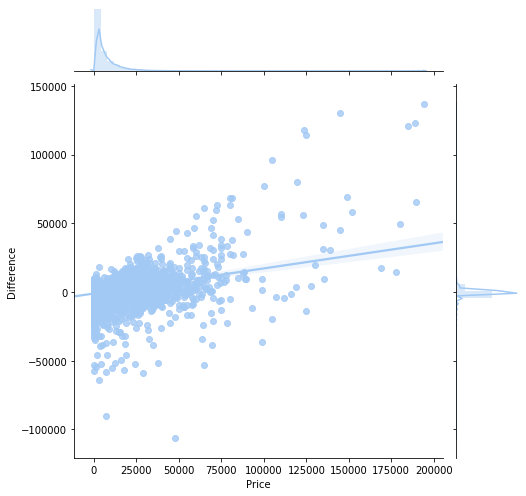

In [153]:
#print out a scatterplot with the real price and the difference to our predictions
sns.jointplot("Price", "Difference", data=compare_price_xgb,
                  kind="reg", truncate=False,
                  color="b", height=7)

In [154]:
compare_price_xgb["Difference"].describe()

count     37313.000000
mean        -15.966556
std        3883.778347
min     -106114.265625
25%        -826.866943
50%         -83.476074
75%         673.126099
max      137031.496094
Name: Difference, dtype: float64

We can see clearly that our classifier gets worse on higher priced cars (the prediction on them is too low).
We can't find a trend in predicting too high or low. But the prediction for low priced cars are more likely too low and vice versa.

___
**Feature Importance**

We want to know which features are the most important in our xgb regressor.

>**Note:** This is just a very short analysis. Find more about model understanding and feature importance in chapter 10.

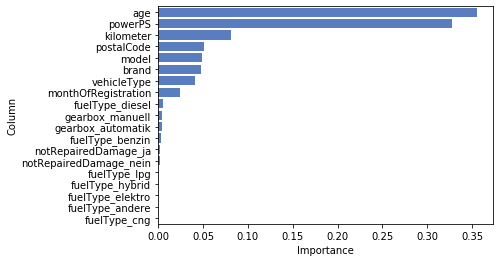

In [229]:
#create a df with the calculated feature importance for our model
pd.DataFrame(
        {"Column": X_train.columns, "Importance": xgb_model.feature_importances_}
    ).sort_values("Importance", ascending=False)

# print out a bar plot for the feature importance
sns.barplot(y="Column", x="Importance", data=feature_importance, color = 'b')

**Findings:**

- Like in Manuels gbr the `powerPS` and `kilometer` features are very important.
- Like we assumed in the beginning of the notebook `age` and `kilometer` are important features.
- It's remarkable that `age` is the most important feature in this model. In Manuels gbr this feature has only a minor importance.

### Histogram-based Gradient Boosting Regression Tree (Created by Simon & Manuel)

Like before we try to improve our model by tuning each single parameter.

In [155]:
model = HistGradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)
print_rf_scores(model)

RMSE on train: 3270.109
R^2 on train: 0.842
RMSE on valid: 3912.064
R^2 on valid: 0.791


___
>**Copyright:** The following concept for analysing hyperparameters is copied from lewis and leandros data science lectures.

In [156]:
rmse_train = []
rmse_valid = []

loss = ['least_squares', 'least_absolute_deviation']
for l in loss:
    hgb = HistGradientBoostingRegressor(loss = l, random_state = 42)
    hgb.fit(X_train, y_train)
    yhat_train = hgb.predict(X_train)
    yhat_valid = hgb.predict(X_valid)
    
    # we append the scores to the list
    rmse_train.append(rmse(y_train, yhat_train))
    rmse_valid.append(rmse(y_valid, yhat_valid))

l_best = loss[np.argmin(rmse_valid)]
l_best

'least_squares'

In [157]:
rmse_train = []
rmse_valid = []

learning_rate = [0.001,0.1,0.2,0.25,0.3,0.5,0.75,1]
for lr in learning_rate:
    hgb = HistGradientBoostingRegressor(loss = l_best, learning_rate = lr, random_state = 42)
    hgb.fit(X_train, y_train)
    yhat_train = hgb.predict(X_train)
    yhat_valid = hgb.predict(X_valid)
    
    # we append the scores to the list
    rmse_train.append(rmse(y_train, yhat_train))
    rmse_valid.append(rmse(y_valid, yhat_valid))

lr_best = learning_rate[np.argmin(rmse_valid)]
lr_best

0.2

In [158]:
rmse_train = []
rmse_valid = []

max_iter = [5,10,20,30,50,100,500,655,800]
for i in max_iter:
    hgb = HistGradientBoostingRegressor(loss = l_best, learning_rate = lr_best, max_iter = i, random_state = 42)
    hgb.fit(X_train, y_train)
    yhat_train = hgb.predict(X_train)
    yhat_valid = hgb.predict(X_valid)
    
    # we append the scores to the list
    rmse_train.append(rmse(y_train, yhat_train))
    rmse_valid.append(rmse(y_valid, yhat_valid))

i_best = max_iter[np.argmin(rmse_valid)]
i_best

655

In [159]:
rmse_train = []
rmse_valid = []

max_leaf_nodes = [10,31,40,100,150,200,500]
for ln in max_leaf_nodes:
    hgb = HistGradientBoostingRegressor(loss = l_best, learning_rate = lr_best, max_iter = i_best,max_leaf_nodes = ln, random_state = 42)
    hgb.fit(X_train, y_train)
    yhat_train = hgb.predict(X_train)
    yhat_valid = hgb.predict(X_valid)
    
    # we append the scores to the list
    rmse_train.append(rmse(y_train, yhat_train))
    rmse_valid.append(rmse(y_valid, yhat_valid))

ln_best = max_leaf_nodes[np.argmin(rmse_valid)]
ln_best

31

In [160]:
rmse_train = []
rmse_valid = []

max_depth = [None,5,10,20,100,200,500]
for d in max_depth:
    hgb = HistGradientBoostingRegressor(loss = l_best, learning_rate = lr_best, max_iter = i_best, max_leaf_nodes = ln_best, max_depth = d, random_state = 42)
    hgb.fit(X_train, y_train)
    yhat_train = hgb.predict(X_train)
    yhat_valid = hgb.predict(X_valid)
    
    # we append the scores to the list
    rmse_train.append(rmse(y_train, yhat_train))
    rmse_valid.append(rmse(y_valid, yhat_valid))

d_best = max_depth[np.argmin(rmse_valid)]
d_best

>**Note:** if no value is printed, d_best = None

In [161]:
rmse_train = []
rmse_valid = []

validation_fraction = [0.0000001,0.0001,0.001,0.01,0.1,0.2,0.5,0.8]
for v in validation_fraction:
    hgb = HistGradientBoostingRegressor(loss = l_best, learning_rate = lr_best, max_iter = i_best,max_leaf_nodes = ln_best, max_depth = d_best, validation_fraction = v, random_state = 42)
    hgb.fit(X_train, y_train)
    yhat_train = hgb.predict(X_train)
    yhat_valid = hgb.predict(X_valid)
    
    # we append the scores to the list
    rmse_train.append(rmse(y_train, yhat_train))
    rmse_valid.append(rmse(y_valid, yhat_valid))

v_best = validation_fraction[np.argmin(rmse_valid)]
v_best

1e-07

In [162]:
hgb = HistGradientBoostingRegressor(loss = l_best, learning_rate = lr_best, max_iter = i_best,max_leaf_nodes = ln, max_depth = d_best, validation_fraction = v, random_state = 42)
hgb.fit(X_train, y_train)
print_rf_scores(hgb)

#print out the model parameters for later
hgb

RMSE on train: 812.671
R^2 on train: 0.99
RMSE on valid: 3854.463
R^2 on valid: 0.797


HistGradientBoostingRegressor(l2_regularization=0.0, learning_rate=0.2,
                              loss='least_squares', max_bins=255,
                              max_depth=None, max_iter=655, max_leaf_nodes=500,
                              min_samples_leaf=20, n_iter_no_change=None,
                              random_state=42, scoring=None, tol=1e-07,
                              validation_fraction=0.8, verbose=0,
                              warm_start=False)

In [163]:
predictionshgb = hgb.predict(X_valid)

In [164]:
# create a submission DataFrame
compare_price_hgb = pd.DataFrame(columns=['Price', 'Predictions', 'Difference'])
#fill the columns
compare_price_hgb['Price'] = y_valid
compare_price_hgb['Predictions'] = predictionshgb
compare_price_hgb['Difference'] = compare_price_hgb['Price'] - compare_price_hgb['Predictions']
#check if all worked fine
compare_price_hgb.head()

,Price,Predictions,Difference
0,7599,7694.635246,-95.635246
1,11999,2883.560846,9115.439154
2,56900,37112.866816,19787.133184
3,3000,4446.394719,-1446.394719
4,1555,2367.310521,-812.310521


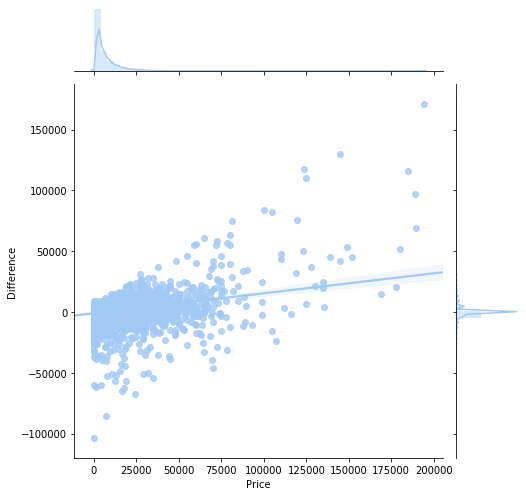

In [165]:
#print out a scatterplot with the real price and the difference to our predictions
sns.jointplot("Price", "Difference", data=compare_price_hgb,
                  kind="reg", truncate=False,
                  color="b", height=7)

In [166]:
pred_rf = rf.predict(X_valid)
pred_gbr = gbr.predict(X_valid)

### Stacked/Blended Model (Created by Simon)

To really outperform in the challenge we will not choose the best model from above and simply make predictions with that.
Crazy as we are we will take all of these models and blend together a super model.
The idea is adapted from Lavanya [Shukla's notebook on kaggle](https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition "Kaggle") but the code is all self written.
This method makes the final predictions more robust to overfitting.

At first we want to try if the concept works and actually gives better results. We will try to blend the predictions of a RandomForest and a GradientBoosting model.

#### Simple Blended Model (RF / GBR)

For this stacked/blended model we used `RandomForestRegressor`and `GradientBoostingRegressor`with the best hyperparameters from the `chapters 1.8.2 Random Forest Regressor and 1.8.4 Gradient Boosting Regressor.`
First step is to fit both models on the train set. For this we copy the tuned models from above.

In [171]:
rf = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=16, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=10, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
rf.fit(X_train, y_train)
print_rf_scores(rf)

RMSE on train: 2519.229
R^2 on train: 0.906
RMSE on valid: 3768.534
R^2 on valid: 0.806


In [172]:
gbr = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls',
                          max_depth=30, max_features='sqrt',
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=1, min_samples_leaf=6,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=200, n_iter_no_change=None,
                          presort='deprecated', random_state=42, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)
gbr.fit(X_train, y_train)
print_rf_scores(gbr)

RMSE on train: 968.317
R^2 on train: 0.986
RMSE on valid: 3555.837
R^2 on valid: 0.828


In [173]:
#import sys for the error handling 3555.837
import sys

def blended_prediction(X, w_rf, w_gbr):
    """
    Makes predictions with multiple regressors (which are trained in advance) and combines them with a weighting.
    The different regression models need to be trained in advance!
    
    - Needs a feature matrix to predict on.
    
    - Returns a pd.series of predictions.
    
    Note: It would be better to store the models in an array and feed them to the function.
    """
    #error handling when the weightings are wrong
    if (w_rf + w_gbr) != 1:
        sys.exit('Error: the weightings must add up to 1')
        
    
    
    predictions = ((w_rf * rf.predict(X)) +
                   (w_gbr * gbr.predict(X)))
    
    return predictions

In [174]:
def print_rmse_score_blended_model(w_rf = 0.85, w_gbr = 0.15):
    """
    Generates RMSE score from blended model and print it out.
    """

    yhat_train = blended_prediction(X_train,w_rf, w_gbr)
    yhat_valid = blended_prediction(X_valid,w_rf, w_gbr)

    scores = {
        "RMSE on train:": rmse(y_train, yhat_train),
        "RMSE on valid:": rmse(y_valid, yhat_valid)
    }

    for score_name, score_value in scores.items():
        print(score_name, round(score_value, 3))

In [175]:
#let the models predict on the validation set and print the score
print_rmse_score_blended_model(0.5, 0.5)

RMSE on train: 1676.551
RMSE on valid: 3593.349


We get a score which is not better than both single models. But also not in the mean of both scores, that's a good sign!

Maybe the score gets better when we look for the best blending ratio.
In the iteration below we will check for the ratio which gives the best score on the validation set.

best RF ratio: 0.12


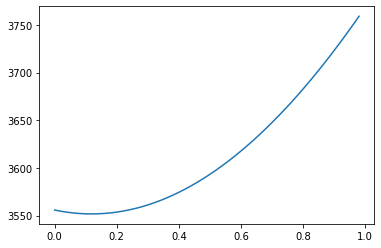

In [176]:
#let both model predict on the validation set
pred_rf = rf.predict(X_valid)
pred_gbr = gbr.predict(X_valid)

#initialize the list for the predictions
preds_list = []

#iterate over each possible ratio
for i in np.arange(0,1,0.02):
    yhat_valid = ((i * pred_rf) + ((1-i) * pred_gbr))
    preds_list.append(rmse(y_valid, yhat_valid))

#search for the best combination in the lists
minimum = preds_list.index(min(preds_list))
best = np.arange(0,1,0.02)[minimum]

#print out the best score
print('best RF ratio: ' + str(best))

#plot out the rmse score for the different ratios (x axis = ratio of RF)
plt.plot(np.arange(0,1,0.02),preds_list)

This graph shows us the best proportion of both regressors for the `stacked/blended model`. The value `best value` given is the percentage of the `RandomForestRegressor`. Hence, the amount used of the `GradientBoostingRegressor`is `1 - best value`, so that the model performes the best.

In [177]:
#let's test our results from the graph
print_rmse_score_blended_model(0.12, 0.88)

RMSE on train: 1111.567
RMSE on valid: 3551.785


Now we can see a slight improvement to the singel models. So we stick to the plan and try to make a larger stacked model.

In [178]:
predictionssb = 0.12*rf.predict(X_valid)+0.88*gbr.predict(X_valid)

In [179]:
# create a submission DataFrame
compare_price_sb = pd.DataFrame(columns=['Price', 'Predictions', 'Difference'])
#fill the columns
compare_price_sb['Price'] = y_valid
compare_price_sb['Predictions'] = predictionssb
compare_price_sb['Difference'] = compare_price_sb['Price'] - compare_price_sb['Predictions']
#check if all worked fine
compare_price_sb.head()

,Price,Predictions,Difference
0,7599,7498.643434,100.356566
1,11999,2904.859331,9094.140669
2,56900,37812.607377,19087.392623
3,3000,4676.661654,-1676.661654
4,1555,1039.401434,515.598566


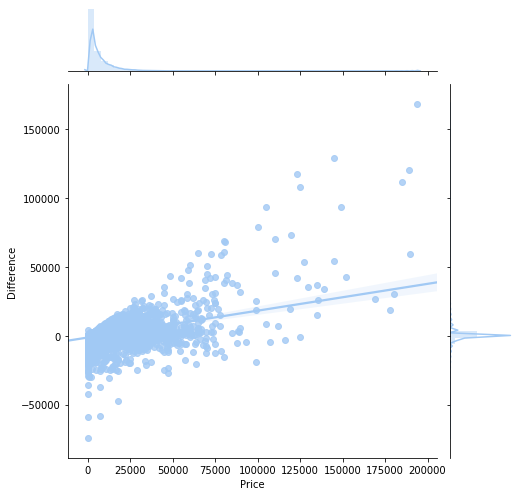

In [180]:
#print out a scatterplot with the real price and the difference to our predictions
sns.jointplot("Price", "Difference", data=compare_price_sb,
                  kind="reg", truncate=False,
                  color="b", height=7)

In [181]:
compare_price_sb["Difference"].describe()

count     37313.000000
mean       -100.275975
std        3550.417199
min      -74115.945509
25%        -805.375925
50%        -112.461863
75%         489.781161
max      168664.315368
Name: Difference, dtype: float64

#### Huge Blended Model (aka The Destroyer)

Since we have tuned more than just the two models above, we would be stupid to waste our work. We want to blend all models we've tuned in the previous chapters.

In [182]:
#initialize the hgb model
hgb = HistGradientBoostingRegressor(l2_regularization=0.0, learning_rate=0.2,
                              loss='least_squares', max_bins=255,
                              max_depth=None, max_iter=655, max_leaf_nodes=500,
                              min_samples_leaf=20, n_iter_no_change=None,
                              random_state=42, scoring=None, tol=1e-07,
                              validation_fraction=0.8, verbose=0,
                              warm_start=False)
hgb.fit(X_train, y_train)
print_rf_scores(hgb)

RMSE on train: 812.671
R^2 on train: 0.99
RMSE on valid: 3854.463
R^2 on valid: 0.797


In [183]:
xgb_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=100000, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.5, max_delta_step=0, max_depth=8,
             min_child_weight=0, missing=None, monotone_constraints='()',
             n_estimators=28, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None, eval_metric='rmse')

xgb_model.fit(X_train, y_train)
print_rf_scores(xgb_model)

RMSE on train: 2487.887
R^2 on train: 0.909
RMSE on valid: 3883.759
R^2 on valid: 0.794


In [184]:
#let every regressor predict on the validation set
pred_rf = rf.predict(X_valid)
pred_gbr = gbr.predict(X_valid)
pred_hgb = hgb.predict(X_valid)
pred_xgb = xgb_model.predict(X_valid)

#initialize the variables
preds_list = []
best = 10000000


#iterate through all possible ratios
for n_rf in np.arange(0,1,0.02):
    for n_hgb in np.arange(0,1,0.02):
        for n_xgb in np.arange(0,1,0.02):
            
            
            #we don't need to calculate the score when the ratios are above 1
            if n_rf+n_hgb+n_xgb > 1:
                break

            #calculate the ratio for gbr
            n_gbr = 1-(n_rf+n_hgb+n_xgb)

            #blend the predictions to a single validation 
            yhat_valid = ((n_rf * pred_rf) + \
                          (n_gbr * pred_gbr) + \
                          (n_xgb * pred_xgb) + \
                          (n_hgb * pred_hgb))

            #calculate the RMSE score
            score = rmse(y_valid, yhat_valid)

            #if the score is better than the best we want to save the ratios
            if score < best:
                best = score
                rf_best = n_rf
                gbr_best = n_gbr
                xgb_best = n_xgb
                hgb_best = n_hgb
                

#print out the results
print('best score = ' + str(best))
print('best value for rf = ' + str(rf_best))
print('best value for gbr = ' + str(gbr_best))
print('best value for xgb = ' + str(xgb_best))
print('best value for hgb = ' + str(hgb_best))

best score = 3510.062595483944
best value for rf = 0.0
best value for gbr = 0.66
best value for xgb = 0.18
best value for hgb = 0.16


In [185]:
yhat_train = (rf_best*rf.predict(X_train)+ \
              gbr_best*gbr.predict(X_train)+ \
            xgb_best*xgb_model.predict(X_train)+ \
              hgb_best*hgb.predict(X_train) \
             )

yhat_valid = (rf_best*rf.predict(X_valid)+ \
              gbr_best*gbr.predict(X_valid)+ \
              xgb_best*xgb_model.predict(X_valid)+ \
              hgb_best*hgb.predict(X_valid) \
             )

scores = {
    "RMSE on train:": rmse(y_train, yhat_train),
    "RMSE on valid:": rmse(y_valid, yhat_valid)
}

for score_name, score_value in scores.items():
    print(score_name, round(score_value, 3))

RMSE on train: 1120.488
RMSE on valid: 3510.063


In [186]:
predictionshb = rf_best*rf.predict(X_valid)+ \
              gbr_best*gbr.predict(X_valid)+ \
              xgb_best*xgb_model.predict(X_valid)+ \
              hgb_best*hgb.predict(X_valid)

In [187]:
# create a submission DataFrame
compare_price_hb = pd.DataFrame(columns=['Price', 'Predictions', 'Difference'])
#fill the columns
compare_price_hb['Price'] = y_valid
compare_price_hb['Predictions'] = predictionshb
compare_price_hb['Difference'] = compare_price_hb['Price'] - compare_price_hb['Predictions']
#check if all worked fine
compare_price_hb.head()

,Price,Predictions,Difference
0,7599,7578.943734,20.056266
1,11999,2975.624035,9023.375965
2,56900,36952.551930,19947.448070
3,3000,4643.379859,-1643.379859
4,1555,1240.150288,314.849712


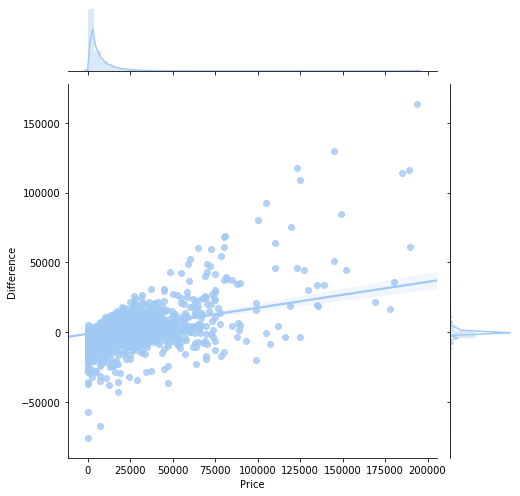

In [188]:
#print out a scatterplot with the real price and the difference to our predictions
sns.jointplot("Price", "Difference", data=compare_price_hb,
                  kind="reg", truncate=False,
                  color="b", height=7)

In [189]:
compare_price_hb["Difference"].describe()

count     37313.000000
mean        -68.500456
std        3509.441151
min      -75709.253614
25%        -766.945800
50%        -106.497189
75%         509.130044
max      163737.274632
Name: Difference, dtype: float64

## Model selection

We now want to compare every model we've trained and then select the best to predict on our test set.
It should be the huge blended model. But we want to be shure and prove it.

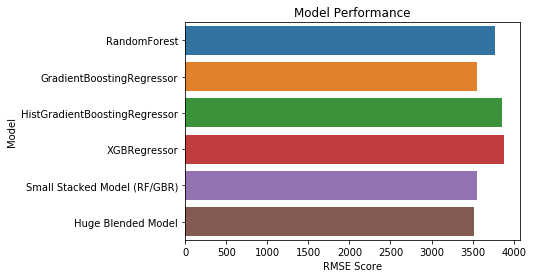

In [190]:
#first we collect all RMSE scores on validation data from all the  tuned models

model_scores = pd.DataFrame(columns=["Model", "RMSE Score"])

model_scores = [ ('RandomForest', 3768.534) ,
             ('GradientBoostingRegressor', 3555.837) ,
             ('HistGradientBoostingRegressor', 3854.463) ,
             ('XGBRegressor', 3883.759) ,
            ('Small Stacked Model (RF/GBR)', 3551.785) ,
            ('Huge Blended Model', 3514.15)
               ]

#Create a DataFrame
model_scores = pd.DataFrame(model_scores, columns = ['Model', 'RMSE Score']) 

#plot out the RMSE scores to compare them
plt.title('Model Performance')
plt.xlabel('RMSE')
sns.set_color_codes("muted")
sns.barplot(x="RMSE Score", y="Model", data=model_scores)

As we can see the huge blended model performs the best!! So we will make our final predictions with this.

## Model Interpretation / Feature Importance

In most "real world cases" we don't want to just improve our kaggle score. In most cases we want to interpret our score and explain the results and the model behaviour to a customer.
For this we will try to find out which features are important and which are not.

From our previous work we guess that the features `age, powerPS, kilometer and notRepairedDamage` have the biggest impact on the price. But let's figure it out.

Because we couldn't figure out how to adapt the following process to our stacked model we will just analyze the feature importance for the `RandomForest` model.

In [191]:
model = RandomForestRegressor()
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [192]:
#create a function which returns a df with rf feature importance
def model_feature_importance(fitted_model, df):
    """
    A function which returns a df with the feature importance of a previosly trained model.
    
    Args: 
    fitted_model: a previously trained sklearn model
    df: pandas data frame with all columns on which we want to know the importance
    """
    return pd.DataFrame(
        {"Column": df.columns, "Importance": fitted_model.feature_importances_}
    ).sort_values("Importance", ascending=False)

What feature_importance does is, it shuffels the values in one column and make the predictions again. The importance is the number of how the model score changes for shuffling each features values.
Shuffling the values and then look at the performance is better because by just dropping columns relationships between columns get lost. 

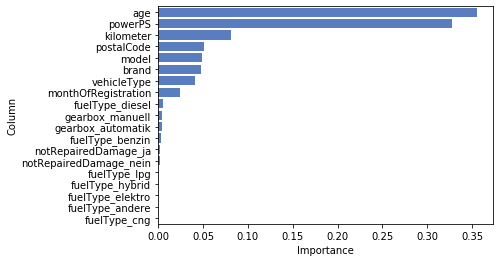

In [193]:
# expected shape - (n_features, 2)
feature_importance = model_feature_importance(model, X_train)

# print out a bar plot for the feature importance
sns.barplot(y="Column", x="Importance", data=feature_importance, color = 'b')

We can see that our guess wasn't that bad. `age`, `powerPS`, and `kilometer` are actually the three most important features.

We can see two drops of importance (between `powerPS` / `kilometer` and `monthOfRegistration` / `notRepairedDamage_ja`). That the importance drops at a point is actually a very common characteristic.

Let's see what we would loose when we would drop the features below the second threshold (`monthOfRegistration`).

In [194]:
#first print the score of the model with all columns
print_rf_scores(model)

RMSE on train: 1341.472
R^2 on train: 0.973
RMSE on valid: 4102.239
R^2 on valid: 0.771


In [195]:
#set a threshold for the feature importance
feature_importance_threshold = 0.01
#create a list with columns above the threshold
cols_to_keep = feature_importance[feature_importance['Importance'] > feature_importance_threshold]['Column']

#save the large feature matrix for later
X_valid_copy = X_valid
X_train_copy = X_train

#create a new feature matrix for train and validation set
X_train_reduced = X_train[cols_to_keep]
X_valid_reduced = X_valid[cols_to_keep]

In [196]:
#initialize a simple rf model
model = RandomForestRegressor()
model.fit(X_train_reduced, y_train)
#print out the RMSE score
yhat_valid = model.predict(X_valid_reduced)
rmse(y_valid, yhat_valid)

4170.278124760821

Our RMSE score has declined by 130 points but the understanding of the model is much better.

Let's see how the model predicts when we just build with 'age' and 'powerPS'.

In [198]:
#create a new feature matrix for train and validation set
X_train_reduced = X_train[['age', 'powerPS']]
X_valid_reduced = X_valid[['age', 'powerPS']]

#initialize a simple rf model
model = RandomForestRegressor()
model.fit(X_train_reduced, y_train)
#print out the RMSE score
yhat_valid = model.predict(X_valid_reduced)
rmse(y_valid, yhat_valid)

4833.086367487257

We want to compare this score with the most simplest model (predicting the mean)

In [199]:

yhat_valid = pd.Series(y_train.mean())
yhat_valid = yhat_valid.repeat(y_valid.size)
rmse(y_valid, yhat_valid)

8563.763245259122

With just these two features we are able to predict with a RMSE of 4871 almost twice as good as just predicting the mean.

___
Like we've guessed at the very beginning of the notebook the predictions are mainly based on just a few features.
In a business case we would probably reduce our features to the most necessary ones so we can better interpret and justify our results.

But since this is a Kaggle competition and we want to get the best possible score we want to keep our columns.



## Make Predictions on Test Set

In [200]:
#load the test set
test = pd.read_csv(datapath/'test.csv')

In [201]:
# create a submission DataFrame
submission = pd.DataFrame(columns=['Id', 'Predicted'])
#make the Id column same as the test['carId'] column
submission['Id'] = test['carId']
#check if all worked fine
submission.head()

,Id,Predicted
0,248923,NaN
1,248924,NaN
2,248925,NaN
3,248926,NaN
4,248927,NaN


### Prepare the Test Set

We want to prepare the test set same as the validation set. The only difference is that we apply one hot encoding directly before change the categores into numerical.

In [202]:
# create the age feature
test['dateCrawled'] = pd.to_datetime(test['dateCrawled'])
test['age'] = test['dateCrawled'].dt.year - test['yearOfRegistration']
test.drop(['yearOfRegistration'], axis = 1, inplace = True)
test['age']

0         17
1          0
2          8
3          7
4          8
          ..
122536    13
122537    23
122538     3
122539    16
122540    17
Name: age, Length: 122541, dtype: int64

In [203]:
#deal with unrealistic value
test.loc[test['age'] < 0, "age"]= 0
test.loc[test['age'] > 106, "age"]= np.nan
test.loc[test['powerPS'] > 1000,"powerPS"]= np.nan

In [204]:
test.isnull().sum()

carId                      0
dateCrawled                0
name                       0
seller                     0
offerType                  0
abtest                     0
vehicleType            12296
gearbox                 6588
powerPS                  103
model                   6738
kilometer                  0
monthOfRegistration        0
fuelType               11005
brand                      0
notRepairedDamage      23701
dateCreated                0
nrOfPictures               0
postalCode                 0
lastSeen                   0
age                       22
dtype: int64

In [205]:
 #fill missing values with the same method we used in the train set
test['vehicleType'].fillna(test['vehicleType'].mode()[0], inplace=True)
test['gearbox'].fillna(test['gearbox'].mode()[0], inplace=True)
test['model'].fillna(test['model'].mode()[0], inplace=True)
test['fuelType'].fillna(test['fuelType'].mode()[0],inplace=True)
test['notRepairedDamage'].fillna(test['notRepairedDamage'].mode()[0], inplace=True)
test['age'].fillna(train['age'].median(), inplace=True)
test['powerPS'].fillna(train['powerPS'].median(), inplace=True)

In [206]:
 #drop same columns we droped in the train set
test.drop(['seller'], axis=1, inplace = True)
test.drop(['carId'], axis=1, inplace = True)
test.drop(['offerType'], axis=1, inplace = True)
test.drop(['dateCrawled'], axis=1, inplace = True)
test.drop(['name'], axis=1, inplace = True)
test.drop(['dateCreated'], axis=1, inplace = True)
test.drop(['lastSeen'], axis=1, inplace = True)
test.drop(['nrOfPictures'], axis=1, inplace = True)
test.drop(['abtest'], axis=1, inplace = True)

In [207]:
#apply the function we used already for the validation set to convert strings into categories
convert_strings_to_categories_train(test)

cat_vehicleType
cat_gearbox
cat_model
cat_fuelType
cat_brand
cat_notRepairedDamage


In [208]:
def convert_categories_to_numeric(df):
    """
        A function to convert all object columns of a dataframe with the Dtype 'category'
        into a numeric Dtype (based on the category codes).
        
    
    """
    for c in df:
        if df[c].dtype.name == 'category':
            df[c] = df[c].cat.codes + 1

In [209]:
#apply one hot encoding to the same columns like we did for the test set
test = pd.get_dummies(test, columns=['gearbox','fuelType','notRepairedDamage'])
#apply the function we already used for the train set to make the remaining categorical columns numeric
convert_categories_to_numeric(test)

In [210]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122541 entries, 0 to 122540
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   vehicleType             122541 non-null  int8   
 1   powerPS                 122541 non-null  float64
 2   model                   122541 non-null  int16  
 3   kilometer               122541 non-null  int64  
 4   monthOfRegistration     122541 non-null  int64  
 5   brand                   122541 non-null  int8   
 6   postalCode              122541 non-null  int64  
 7   age                     122541 non-null  float64
 8   gearbox_automatik       122541 non-null  uint8  
 9   gearbox_manuell         122541 non-null  uint8  
 10  fuelType_andere         122541 non-null  uint8  
 11  fuelType_benzin         122541 non-null  uint8  
 12  fuelType_cng            122541 non-null  uint8  
 13  fuelType_diesel         122541 non-null  uint8  
 14  fuelType_elektro    

In [211]:
#safe processed data as .csv file
test.to_csv(datapath/'test_final.csv', index = False)

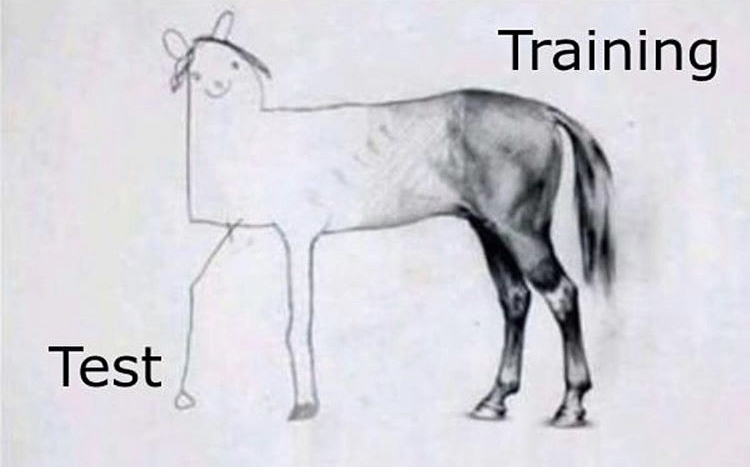

### Make Predictions and Save Results

In [212]:
#load the latest version of the processed test set
test_processed = pd.read_csv(datapath/'test_final.csv')
display_large(test_processed.head(3))

,vehicleType,powerPS,model,kilometer,monthOfRegistration,brand,postalCode,age,gearbox_automatik,gearbox_manuell,fuelType_andere,fuelType_benzin,fuelType_cng,fuelType_diesel,fuelType_elektro,fuelType_hybrid,fuelType_lpg,notRepairedDamage_ja,notRepairedDamage_nein
0,7,82.0,34,150000,7,21,90443,17.0,0,1,0,1,0,0,0,0,0,0,1
1,7,122.0,61,150000,4,21,73525,0.0,0,1,0,1,0,0,0,0,0,0,1
2,2,136.0,236,125000,1,37,36093,8.0,0,1,0,0,0,1,0,0,0,0,1


In [213]:
#fill the submission frame with predictions (single model)
submission['Predicted'] = (rf_best*rf.predict(test_processed)+ \
              gbr_best*gbr.predict(test_processed)+ \
              xgb_best*xgb_model.predict(test_processed)+ \
              hgb_best*hgb.predict(test_processed) \
             )

In [214]:
#save submission frame
submission.to_csv(datapath/'submission.csv', index = False)

## Final Words / Reflection

**Preparation of the datasets** is a essential thing of course. There are thousends of methods and procedures to change the date before training the data. 

We startet by just checking all the data and realized quickly that there is a lot of non-sense data. Therefore we had to change or even remove them to make the score better. But it took too much time until we knew that it is such a big help to always check what is happening with the RMSE score of the model when changing just one thing. Otherwise after changing several things, nobody knew what actually affected the model and its score.
This has cost us a lot of time!

---
**Outliers and Missing Values**
Further, outliers as well as missing values are not allways bad for predictions. Depending on their distribution. Randomly distributed missing values or outliers are for sure not useful for a predictive model. But they also can be logically distributed, which is in fact also an information to use for the model.
And to cut away outliers which can also be found in the test set is not always useful.

> One of the most important and most simple learnings was: **A model can not predict on data which is not represented in the train set!**


It took us some weeks until we realized that, so we had to do some step backs, as it is explained in the notebook about the kNN-method for filling up missing values. 



__Valid__

As we have worked for about 5 weeks on this project, we realized that it would be a huge help to have a valid set which represents the score on kaggle the best (because we applied the same feature engineering on the validation set like on the train set). Before that, we always had to upload a submission to check whether our changes were good or not. Therefore, we have created the valid set at the beginning, before even changing anything on the trainset and then treat the validation set same as the test set.

__Organization__

Right from the beginning, we created a OneDrive folder where all data, the notebook, the datasets, images and more is saved and available for everyone in the team. But we realized, that OneDrive does not reload that fast. Therefore, changes made by one group member, was not in the notebook of another member. 

Furthermore, we messed up the clarity of the notebooks. Hence, we sometimes lost the overview over them. We had several main notebooks, several "sub"-notebooks. this was a high risk.
In next works, we are going to create one main notebook. This is for adapting every improvement, testing out several things and most importantly, having a clear structure with descriptions and so on. Additionally, we will create a second notebook, for example `improve_score`. This is not as clearly structured as the main notebook, but it is useful to generate a better score. Within in, there are no plots, no codes which are not directly influencing the dataset or the RMSE score, so that the whole `improve_score`notebook needs less time to run through. This will increase our efficiency. 

---

__Procedure__

We are not used to coding that much. Therefore, when something was working well, we were a little unstructured. Like said before we changed several things before checking again, if the score improved or not. In the future, we are going to check the RMSE after every single change. We learned that when doing two changes for example, then checking the RMSE,the score could be worse because of one change, although the other one actually improved the score. This decreased our efficiency massively.

---

## Last but not least

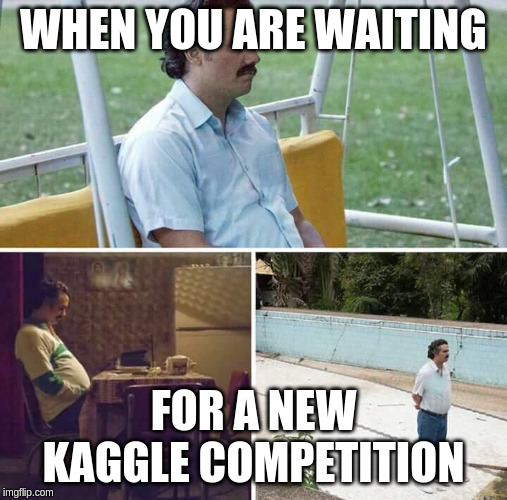